## Diabetes Prediction

Diabetes Prediction Dataset
The provided dataset appears to be related to diabetes and contains various biomedical measurements and patient characteristics. 

🎯 Objective

Develop a predictive model to determine the likelihood of a patient having diabetes based on various biomedical measurements and personal characteristics. Through exploratory data analysis (EDA) and machine learning techniques, the goal is to uncover meaningful patterns that can support early clinical decision-making and enhance prevention and treatment strategies.

## Table Of Content

1. Initialization
2. Exploratory Data Analysis
    - 2.1 Correlation
    - 2.2 A/B Test
    - 2.3 ANOVA
3. Data Models
    - 3.1 One Hot Encoding
    - 3.2 Ordinal Encoding
4. Conclusions

## 1. Initialization

In [233]:
# Standard libraries
import math
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns  # type: ignore
from matplotlib import pyplot as plt

# Statistics
from scipy import stats as st
from scipy.stats import kruskal, levene, mannwhitneyu, shapiro

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, label_binarize

# Class balancing
from imblearn.over_sampling import SMOTE

# Data splitting
from sklearn.model_selection import train_test_split

# Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    roc_auc_score
)

## 2. Data Preprocessing

Let's review the data set

In [234]:
df_diabetes = pd.read_csv('DatasetDiabetes.csv')
print(df_diabetes.info())
print()
df_diabetes.columns = df_diabetes.columns.str.lower()
df_diabetes.columns = df_diabetes.columns.str.replace(' ', '_')
print(df_diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  ----- 

We convert the columns to lowercase

In [235]:
print(df_diabetes.head())

    id  no_pation gender  age  urea  cr  hba1c  chol   tg  hdl  ldl  vldl  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    bmi class  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N  


Let's review Duplicated Data

In [236]:
print("Duplicated Data \n")
print(df_diabetes.duplicated().sum())

Duplicated Data 

0


Let's review Null Data

In [237]:
print("Null Data \n")
print(df_diabetes.isna().sum())

Null Data 

id           0
no_pation    0
gender       0
age          0
urea         0
cr           0
hba1c        0
chol         0
tg           0
hdl          0
ldl          0
vldl         0
bmi          0
class        0
dtype: int64


Data correction

In [238]:
#Gender
df_diabetes['gender'] = df_diabetes['gender'].str.upper()

df_diabetes['class'] = df_diabetes['class'].astype(str)
df_diabetes['class'] = df_diabetes['class'].str.strip().str.upper()

class_mapping = {
    'N': 1,  # Non-diabetic
    'P': 2,  # Prediabetic
    'Y': 3   # Diabetic
    }

df_diabetes['class'] = df_diabetes['class'].replace(class_mapping)

print(df_diabetes['class'].value_counts().sort_index())
print()

#Data Set
print(df_diabetes.head())


class
1    103
2     53
3    844
Name: count, dtype: int64

    id  no_pation gender  age  urea  cr  hba1c  chol   tg  hdl  ldl  vldl  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    bmi  class  
0  24.0      1  
1  23.0      1  
2  24.0      1  
3  24.0      1  
4  21.0      1  


C:\Users\52921\AppData\Local\Temp\ipykernel_9656\2655954682.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diabetes['class'] = df_diabetes['class'].replace(class_mapping)


- Remove spaces before and after and Upper letter
- Replace Values: For easy data management

- 'N': 1 = Non-diabetic
- 'P': 2 = Prediabetic
- 'Y': 3 = Diabetic


## 3. Exploratory Data Analysis (EDA)

Graphs

Mean by Gender
gender
F    53.312644
M    53.693805
Name: age, dtype: float64


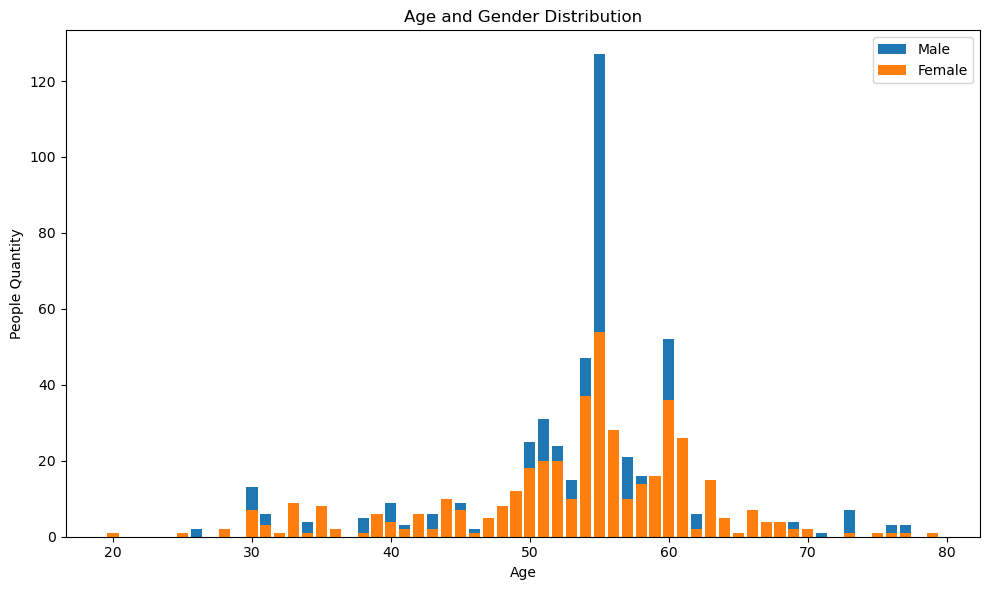

In [239]:
#Gender
df_counts = df_diabetes.groupby(['age'])['gender'].value_counts().sort_index().reset_index()
#print(df_counts)

print("Mean by Gender")
print(df_diabetes.groupby('gender')['age'].mean())

male = df_counts[df_counts['gender'] == 'M']
female = df_counts[df_counts['gender'] == 'F']

plt.figure(figsize=(10, 6))
plt.bar(male['age'], male['count'], label='Male')
plt.bar(female['age'], female['count'], label='Female')
plt.title('Age and Gender Distribution')
plt.xlabel('Age')
plt.ylabel('People Quantity')
plt.legend()
plt.tight_layout()
plt.show()

Peak Screening Age Group
The highest concentration of diabetes screenings occurred around the age of 55, with a significant spike in the number of individuals tested. This suggests that middle-aged adults are the primary demographic undergoing diabetes testing.

Gender Balance
Overall, both males and females are represented across all age groups. However, around the peak (ages 50–60), the number of males slightly exceeds females, indicating a potentially higher concern or risk perception among men in that age range.

Lower Participation in Younger and Older Age Groups
Screening participation is low among individuals under 40 and above 70. This may reflect lower perceived risk in younger populations and potential access or health system barriers for older adults.

Public Health Implication
The data suggests that targeted awareness campaigns could be beneficial for:

Younger adults (20s–30s): to promote early detection.

Older adults (70+): to encourage continued monitoring and check-ups.

Gender-Specific Strategies
While the overall distribution is relatively balanced, tailored communication for both genders may help address any behavioral or cultural barriers to testing, especially in underrepresented age ranges.

Graph per Classes, Gender and Agre

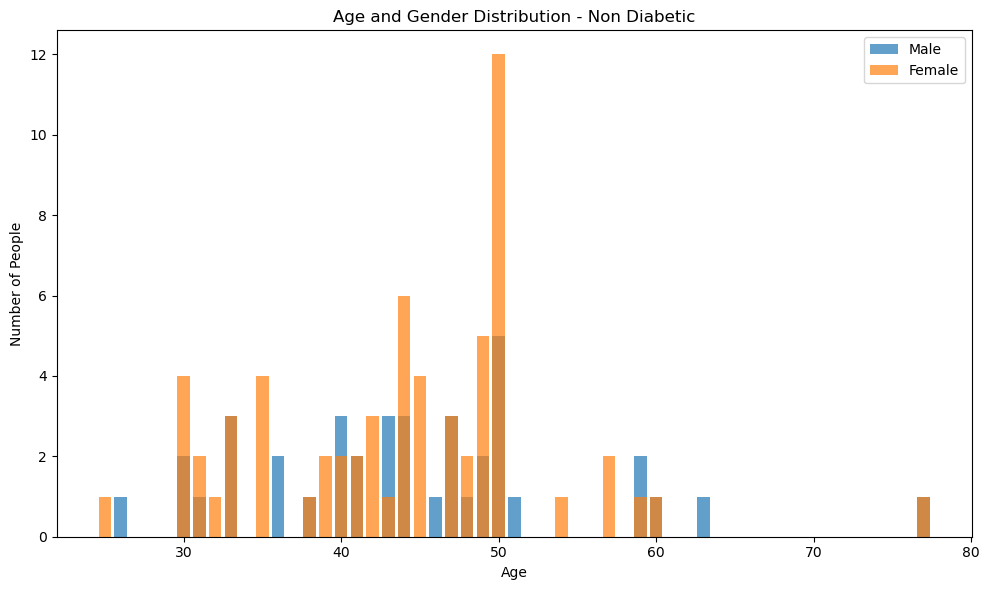


🔎 Total for Non Diabetic:
  👨 Males: 39
  👩 Females: 64
  👥 Total: 103


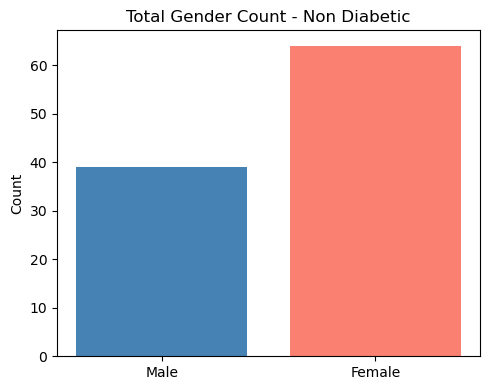

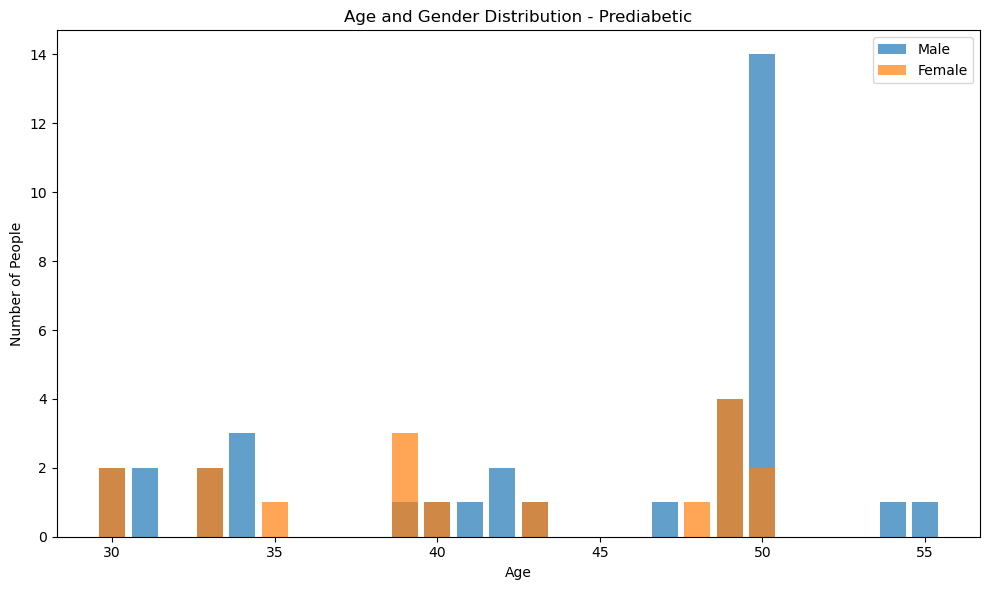


🔎 Total for Prediabetic:
  👨 Males: 36
  👩 Females: 17
  👥 Total: 53


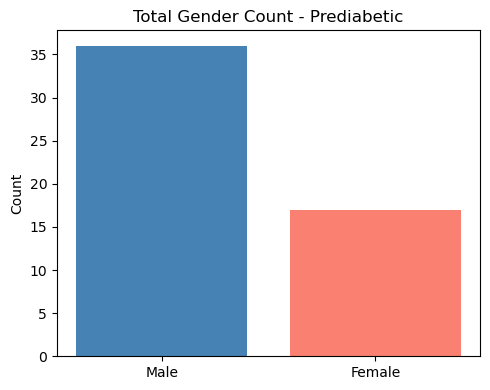

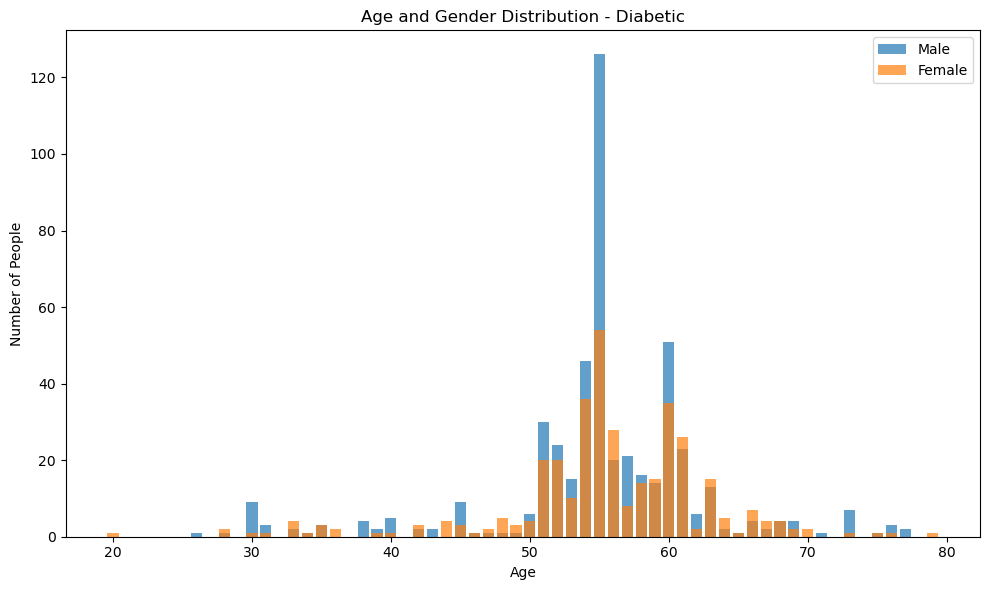


🔎 Total for Diabetic:
  👨 Males: 490
  👩 Females: 354
  👥 Total: 844


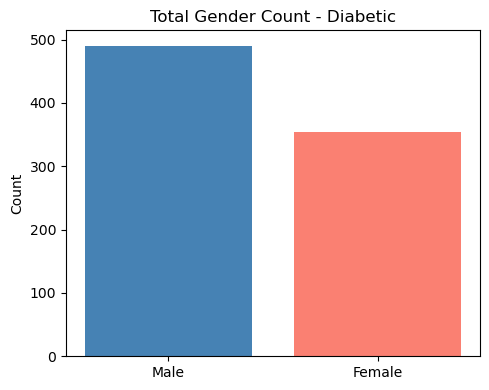

In [240]:
#Group by Age, Gender and Class
df_counts = df_diabetes.groupby(['age', 'gender', 'class']).size().reset_index(name='count')

# Class Labels
class_labels = {1: 'Non Diabetic', 2: 'Prediabetic', 3: 'Diabetic'}

# Classes
classes = [1, 2, 3]

for cls in classes:
    df_class = df_counts[df_counts['class'] == cls]

    male = df_class[df_class['gender'] == 'M']
    female = df_class[df_class['gender'] == 'F']

    # Graph by Age
    plt.figure(figsize=(10, 6))
    plt.bar(male['age'], male['count'], label='Male', alpha=0.7)
    plt.bar(female['age'], female['count'], label='Female', alpha=0.7)
    plt.title(f'Age and Gender Distribution - {class_labels[cls]}')
    plt.xlabel('Age')
    plt.ylabel('Number of People')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Count by Gender and class
    total_males = male['count'].sum()
    total_females = female['count'].sum()

    print(f"\n🔎 Total for {class_labels[cls]}:")
    print(f"  👨 Males: {total_males}")
    print(f"  👩 Females: {total_females}")
    print(f"  👥 Total: {total_males + total_females}")

    # Graph by Gender
    plt.figure(figsize=(5, 4))
    plt.bar(['Male', 'Female'], [total_males, total_females], color=['steelblue', 'salmon'])
    plt.title(f'Total Gender Count - {class_labels[cls]}')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


Analysis by: UREA


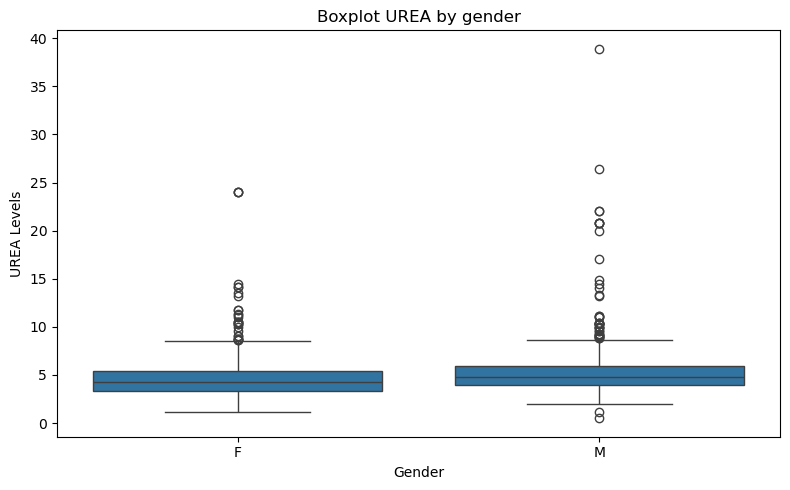

Data Before: 1000
Data After remove outliers: 935


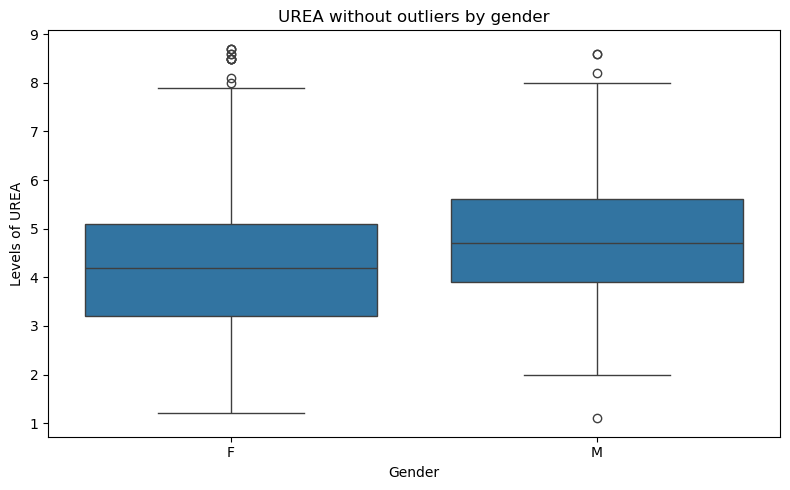


 Stats of UREA by gender (without outliers):

        count      mean       std  min  25%  50%  75%  max
gender                                                    
F       412.0  4.275971  1.492603  1.2  3.2  4.2  5.1  8.7
M       523.0  4.794728  1.325635  1.1  3.9  4.7  5.6  8.6

Analysis by: CR


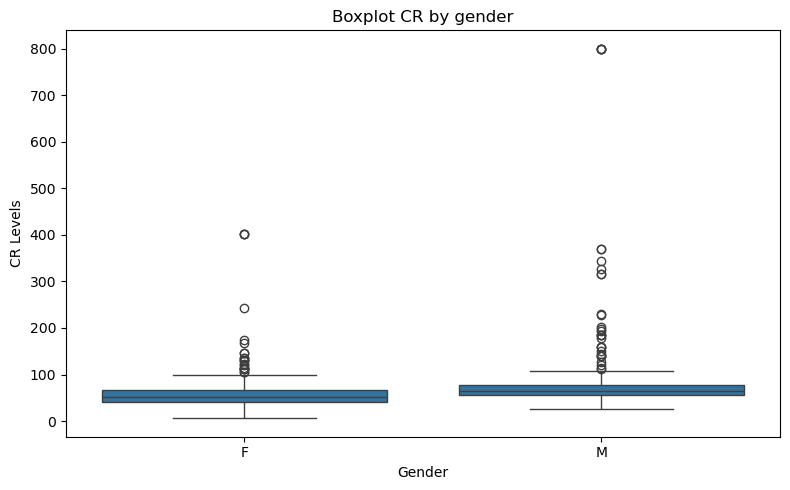

Data Before: 1000
Data After remove outliers: 948


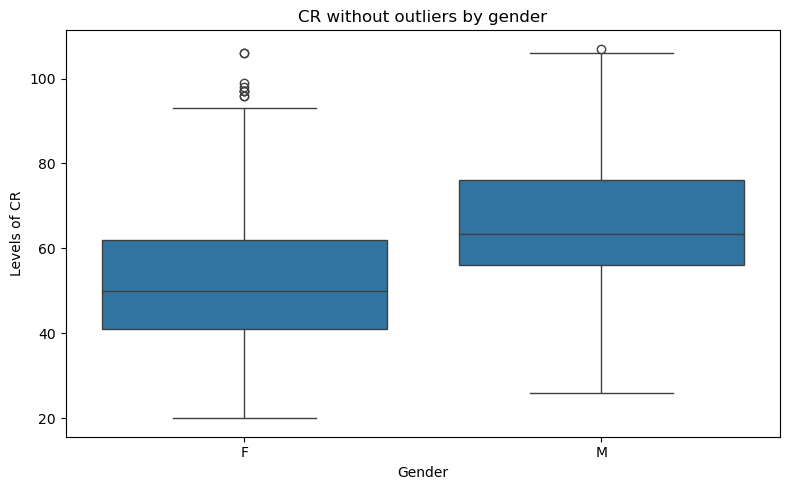


 Stats of CR by gender (without outliers):

        count       mean        std   min   25%   50%   75%    max
gender                                                            
F       414.0  52.731884  16.859858  20.0  41.0  50.0  62.0  106.0
M       534.0  65.295880  15.637501  26.0  56.0  63.5  76.0  107.0

Analysis by: HBA1C


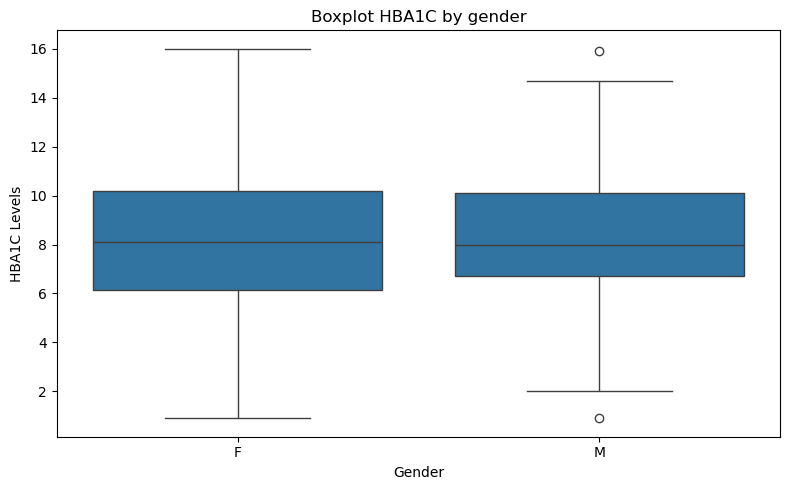

Data Before: 1000
Data After remove outliers: 994


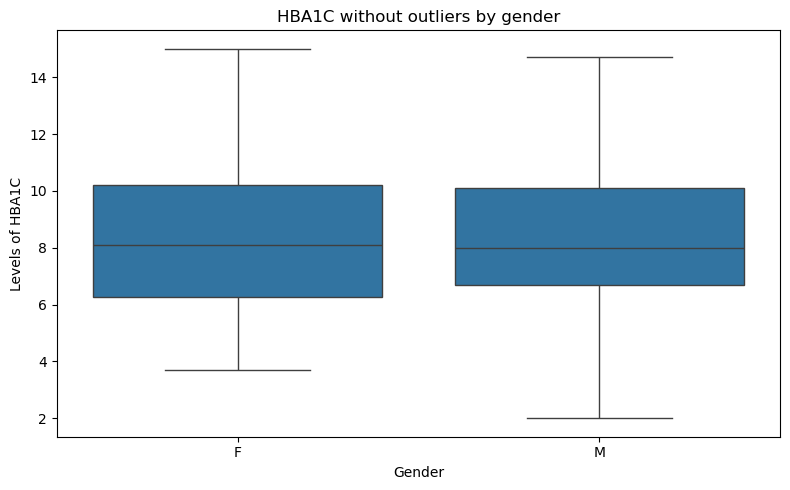


 Stats of HBA1C by gender (without outliers):

        count      mean       std  min   25%  50%   75%   max
gender                                                       
F       431.0  8.341903  2.727090  3.7  6.25  8.1  10.2  15.0
M       563.0  8.259858  2.263525  2.0  6.70  8.0  10.1  14.7

Analysis by: CHOL


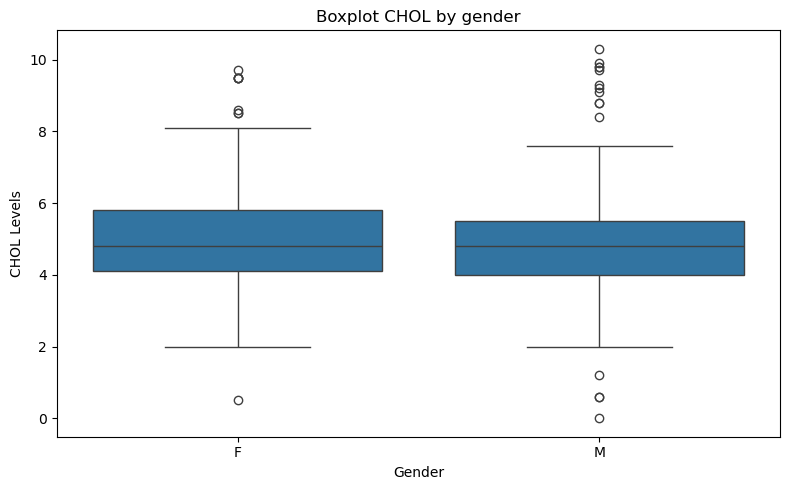

Data Before: 1000
Data After remove outliers: 973


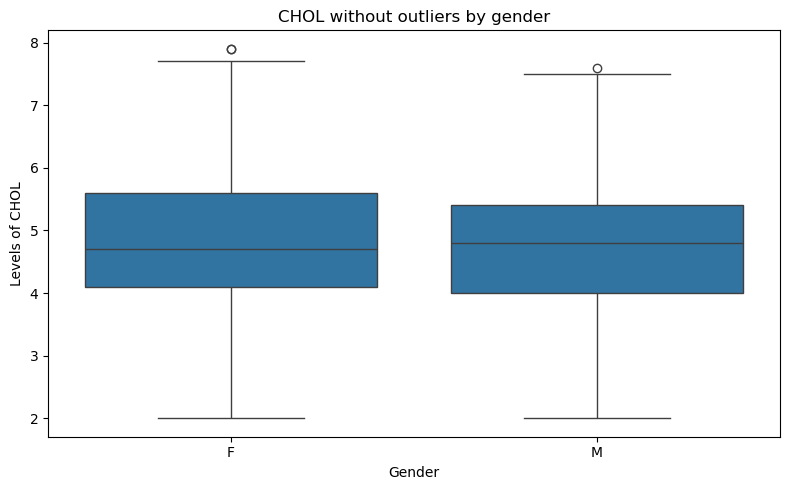


 Stats of CHOL by gender (without outliers):

        count      mean       std  min  25%  50%  75%  max
gender                                                    
F       423.0  4.868085  1.131726  2.0  4.1  4.7  5.6  7.9
M       550.0  4.727673  1.082040  2.0  4.0  4.8  5.4  7.6

Analysis by: TG


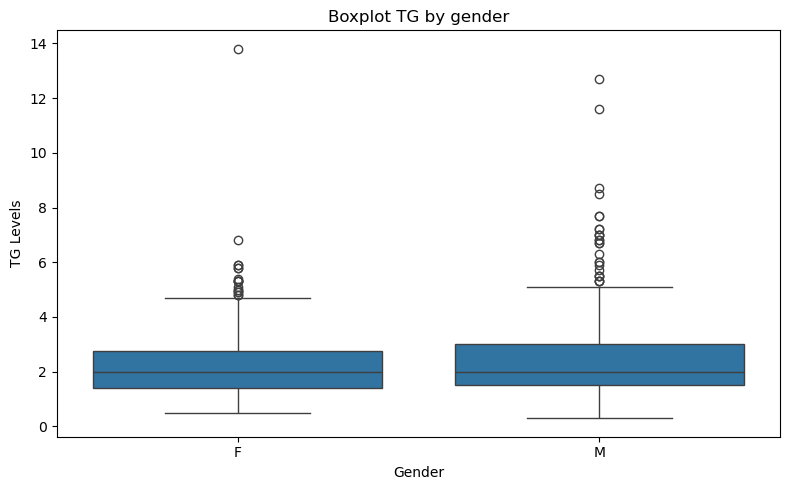

Data Before: 1000
Data After remove outliers: 945


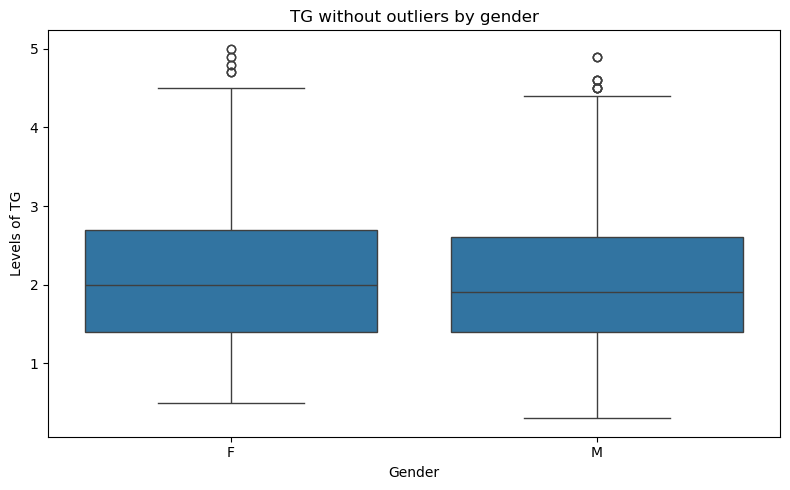


 Stats of TG by gender (without outliers):

        count      mean       std  min  25%  50%  75%  max
gender                                                    
F       423.0  2.151773  1.004488  0.5  1.4  2.0  2.7  5.0
M       522.0  2.098487  0.946105  0.3  1.4  1.9  2.6  4.9

Analysis by: HDL


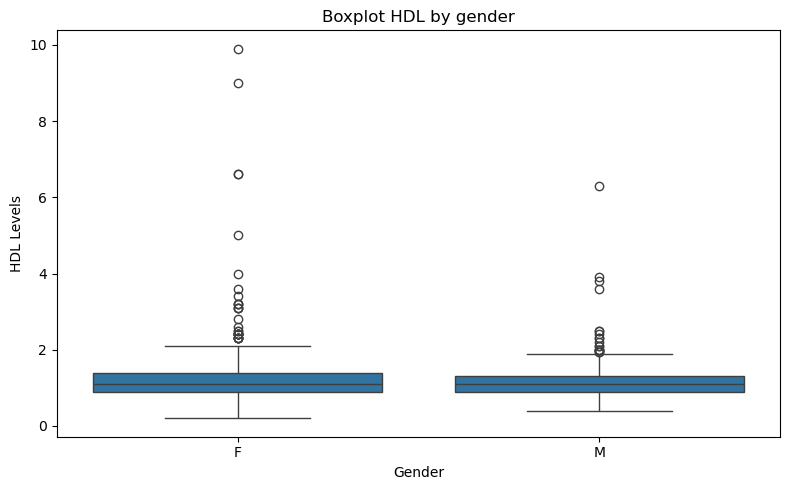

Data Before: 1000
Data After remove outliers: 950


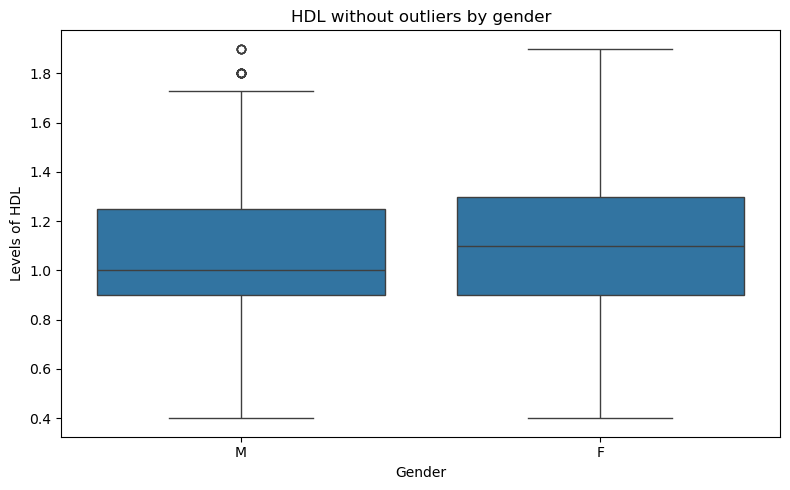


 Stats of HDL by gender (without outliers):

        count      mean       std  min  25%  50%   75%  max
gender                                                     
F       403.0  1.138089  0.316200  0.4  0.9  1.1  1.30  1.9
M       547.0  1.078976  0.303273  0.4  0.9  1.0  1.25  1.9

Analysis by: LDL


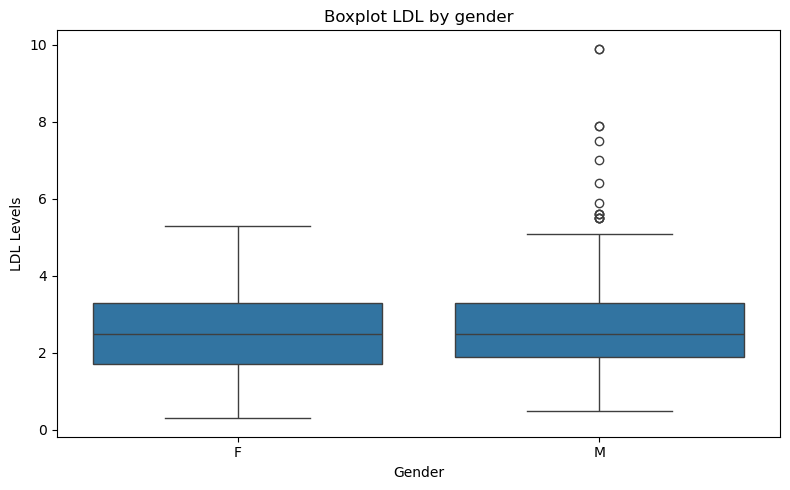

Data Before: 1000
Data After remove outliers: 989


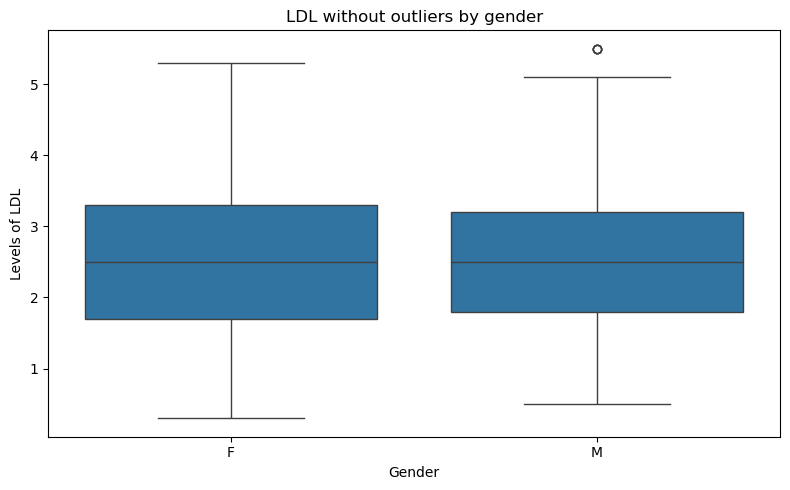


 Stats of LDL by gender (without outliers):

        count      mean       std  min  25%  50%  75%  max
gender                                                    
F       435.0  2.540483  1.044137  0.3  1.7  2.5  3.3  5.3
M       554.0  2.573069  0.959153  0.5  1.8  2.5  3.2  5.5

Analysis by: VLDL


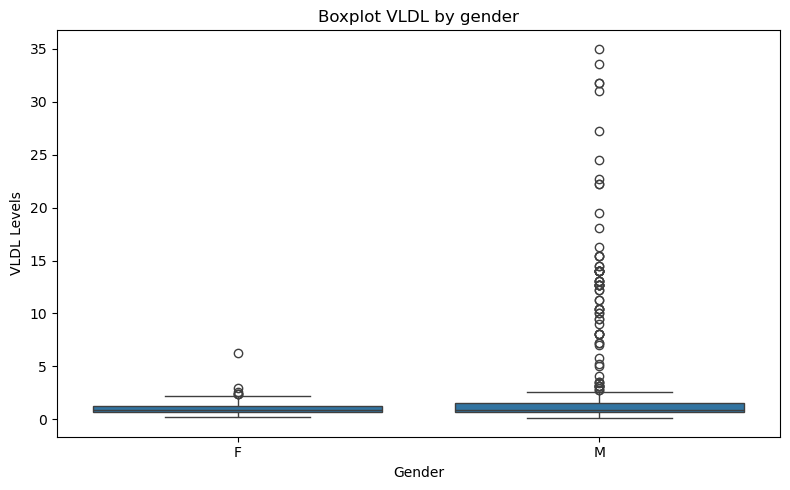

Data Before: 1000
Data After remove outliers: 926


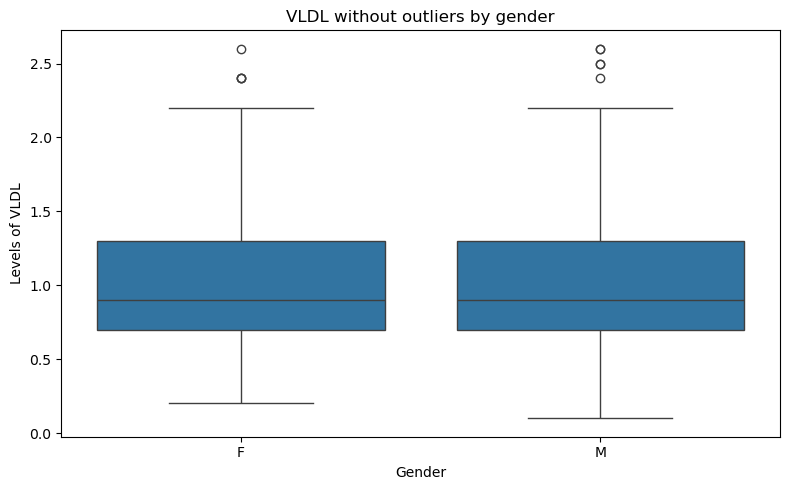


 Stats of VLDL by gender (without outliers):

        count      mean       std  min  25%  50%  75%  max
gender                                                    
F       433.0  1.027945  0.463361  0.2  0.7  0.9  1.3  2.6
M       493.0  1.005071  0.464245  0.1  0.7  0.9  1.3  2.6

Analysis by: BMI


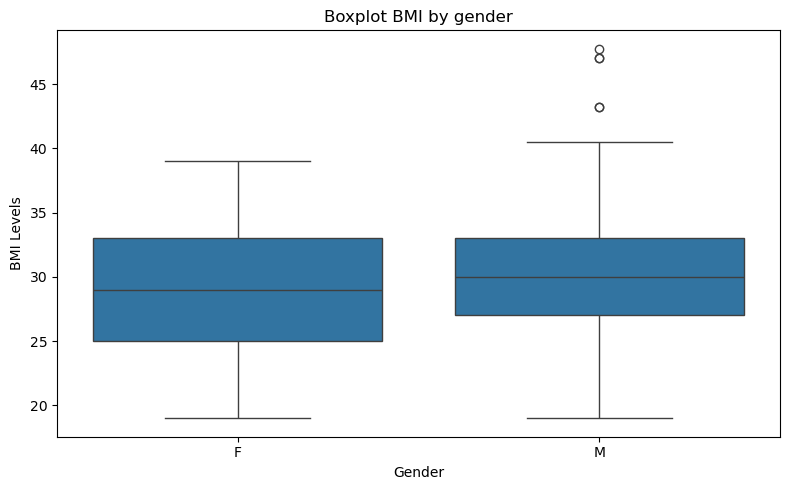

Data Before: 1000
Data After remove outliers: 997


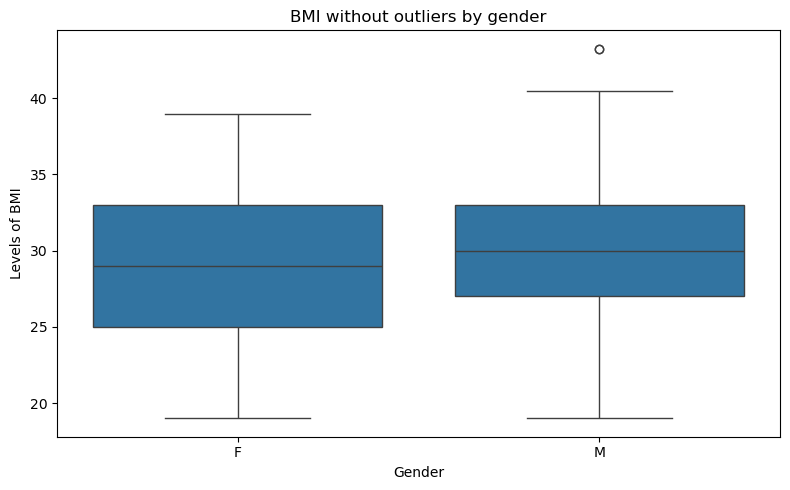


 Stats of BMI by gender (without outliers):

        count       mean       std   min   25%   50%   75%    max
gender                                                           
F       435.0  29.170483  5.129288  19.0  25.0  29.0  33.0  39.00
M       562.0  29.799128  4.652891  19.0  27.0  30.0  33.0  43.25


In [241]:
# Variables to Analyze
columns = ['urea', 'cr', 'hba1c', 'chol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi']

for col in columns:
    print(f"\nAnalysis by: {col.upper()}")

    # Boxplot original con outliers
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_diabetes, x='gender', y=col)
    plt.title(f'Boxplot {col.upper()} by gender')
    plt.xlabel('Gender')
    plt.ylabel(f'{col.upper()} Levels')
    plt.tight_layout()
    plt.show()

    # IQR Calculation & Remove Outliers
    Q1 = df_diabetes[col].quantile(0.25)
    Q3 = df_diabetes[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_no_outliers = df_diabetes[(df_diabetes[col] >= lower_limit) & (df_diabetes[col] <= upper_limit)]

    print(f'Data Before: {len(df_diabetes)}')
    print(f'Data After remove outliers: {len(df_no_outliers)}')

    # Boxplot without Outliers
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_no_outliers, x='gender', y=col)
    plt.title(f'{col.upper()} without outliers by gender')
    plt.xlabel('Gender')
    plt.ylabel(f'Levels of {col.upper()}')
    plt.tight_layout()
    plt.show()

    # Stats
    print(f"\n Stats of {col.upper()} by gender (without outliers):\n")
    print(df_no_outliers.groupby('gender')[col].describe())


🔍 Analysis by: UREA
Data Before: 1000
Data After remove outliers: 935


C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')


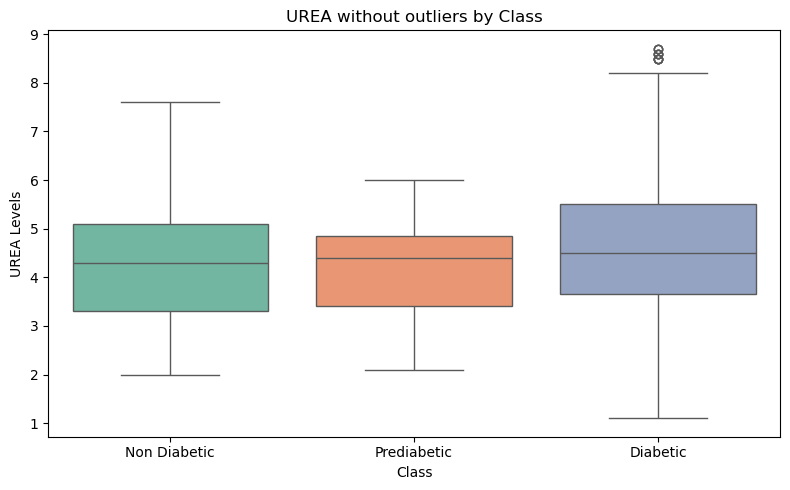


📊 Stats of UREA by Class (without outliers):

              count      mean       std  min   25%  50%   75%  max
class_label                                                       
Diabetic      784.0  4.617784  1.441879  1.1  3.66  4.5  5.50  8.7
Non Diabetic   99.0  4.313131  1.439008  2.0  3.30  4.3  5.10  7.6
Prediabetic    52.0  4.269231  1.001673  2.1  3.40  4.4  4.85  6.0

🔍 Analysis by: CR
Data Before: 1000
Data After remove outliers: 948


C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')


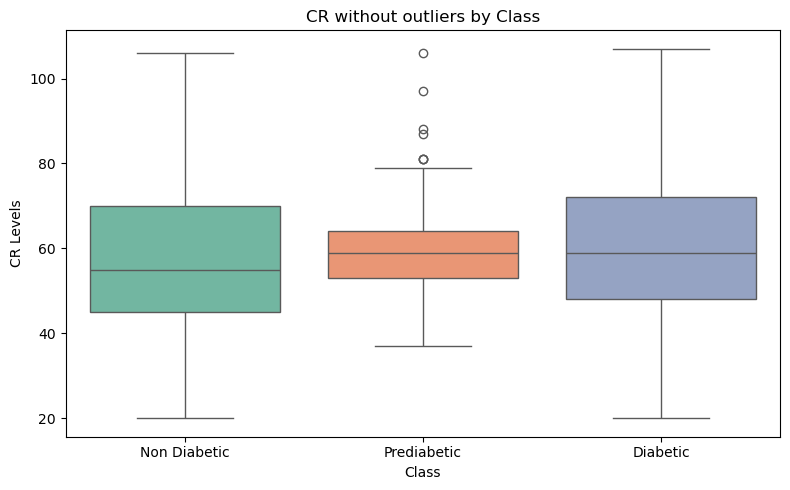

C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')



📊 Stats of CR by Class (without outliers):

              count       mean        std   min   25%   50%   75%    max
class_label                                                             
Diabetic      799.0  59.913642  17.206801  20.0  48.0  59.0  72.0  107.0
Non Diabetic   97.0  58.453608  19.613463  20.0  45.0  55.0  70.0  106.0
Prediabetic    52.0  60.730769  14.763648  37.0  53.0  59.0  64.0  106.0

🔍 Analysis by: HBA1C
Data Before: 1000
Data After remove outliers: 994


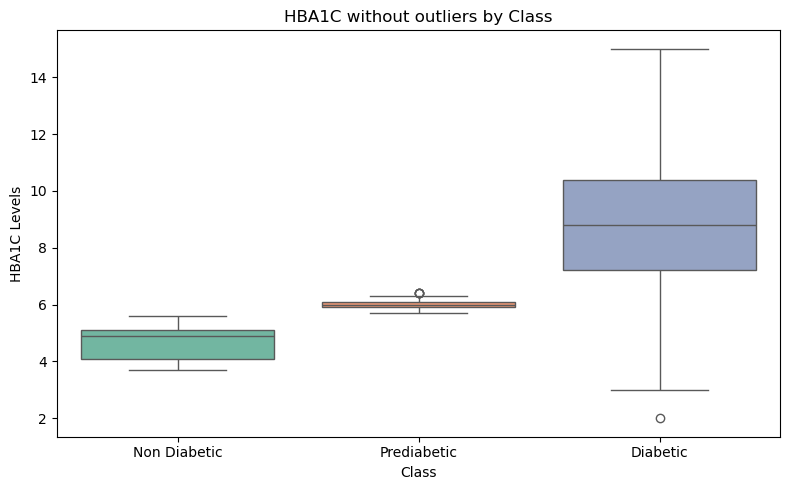


📊 Stats of HBA1C by Class (without outliers):

              count      mean       std  min  25%  50%   75%   max
class_label                                                       
Diabetic      842.0  8.861473  2.241115  2.0  7.2  8.8  10.4  15.0
Non Diabetic   99.0  4.708081  0.562370  3.7  4.1  4.9   5.1   5.6
Prediabetic    53.0  6.003774  0.188069  5.7  5.9  6.0   6.1   6.4

🔍 Analysis by: CHOL
Data Before: 1000
Data After remove outliers: 973


C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')


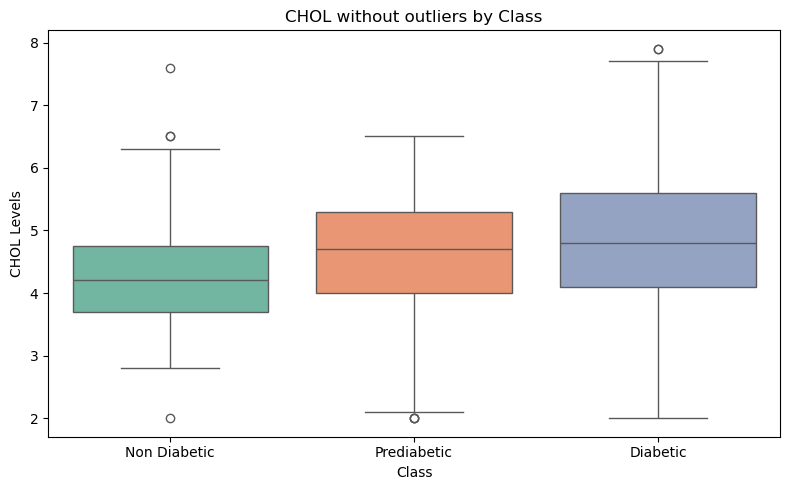

C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')



📊 Stats of CHOL by Class (without outliers):

              count      mean       std  min  25%  50%   75%  max
class_label                                                      
Diabetic      821.0  4.867868  1.112666  2.0  4.1  4.8  5.60  7.9
Non Diabetic   99.0  4.244444  0.900365  2.0  3.7  4.2  4.75  7.6
Prediabetic    53.0  4.579245  1.042991  2.0  4.0  4.7  5.30  6.5

🔍 Analysis by: TG
Data Before: 1000
Data After remove outliers: 945


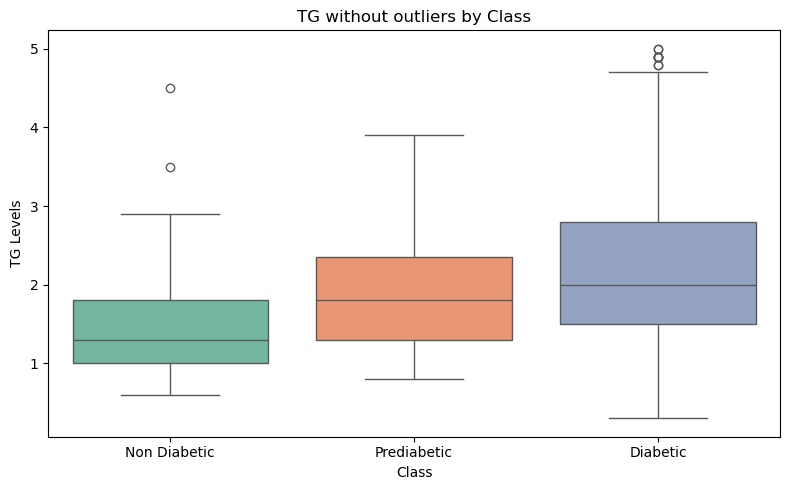


📊 Stats of TG by Class (without outliers):

              count      mean       std  min  25%  50%   75%  max
class_label                                                      
Diabetic      795.0  2.211962  0.981138  0.3  1.5  2.0  2.80  5.0
Non Diabetic   99.0  1.464646  0.647808  0.6  1.0  1.3  1.80  4.5
Prediabetic    51.0  2.001961  0.864983  0.8  1.3  1.8  2.35  3.9

🔍 Analysis by: HDL
Data Before: 1000
Data After remove outliers: 950


C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')


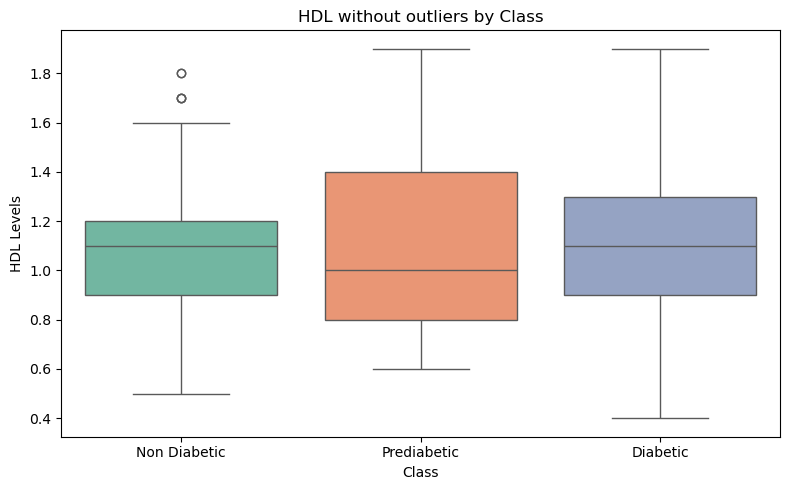


📊 Stats of HDL by Class (without outliers):

              count      mean       std  min  25%  50%  75%  max
class_label                                                     
Diabetic      805.0  1.105714  0.313291  0.4  0.9  1.1  1.3  1.9
Non Diabetic   93.0  1.091398  0.267296  0.5  0.9  1.1  1.2  1.8
Prediabetic    52.0  1.100962  0.334824  0.6  0.8  1.0  1.4  1.9

🔍 Analysis by: LDL
Data Before: 1000
Data After remove outliers: 989


C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')


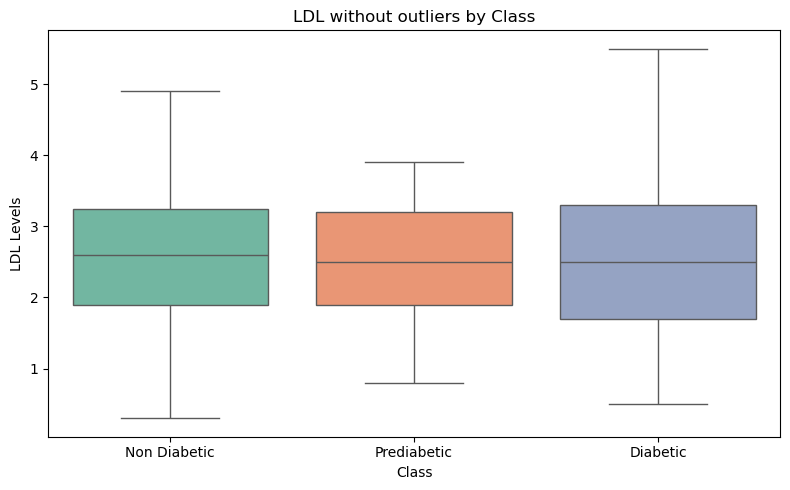

C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')



📊 Stats of LDL by Class (without outliers):

              count      mean       std  min  25%  50%   75%  max
class_label                                                      
Diabetic      833.0  2.554670  1.007183  0.5  1.7  2.5  3.30  5.5
Non Diabetic  103.0  2.625243  0.981367  0.3  1.9  2.6  3.25  4.9
Prediabetic    53.0  2.493396  0.868633  0.8  1.9  2.5  3.20  3.9

🔍 Analysis by: VLDL
Data Before: 1000
Data After remove outliers: 926


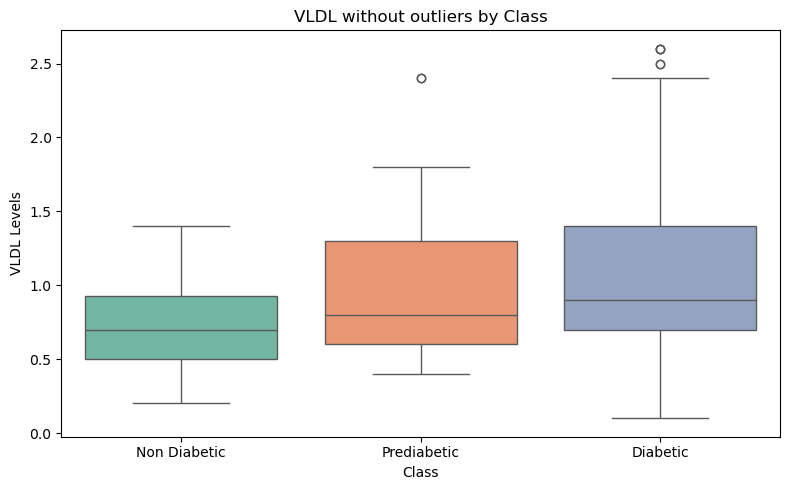

C:\Users\52921\AppData\Local\Temp\ipykernel_9656\1147081246.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')



📊 Stats of VLDL by Class (without outliers):

              count      mean       std  min  25%  50%    75%  max
class_label                                                       
Diabetic      773.0  1.054204  0.467851  0.1  0.7  0.9  1.400  2.6
Non Diabetic  100.0  0.736000  0.280879  0.2  0.5  0.7  0.925  1.4
Prediabetic    53.0  0.983019  0.501818  0.4  0.6  0.8  1.300  2.4

🔍 Analysis by: BMI
Data Before: 1000
Data After remove outliers: 997


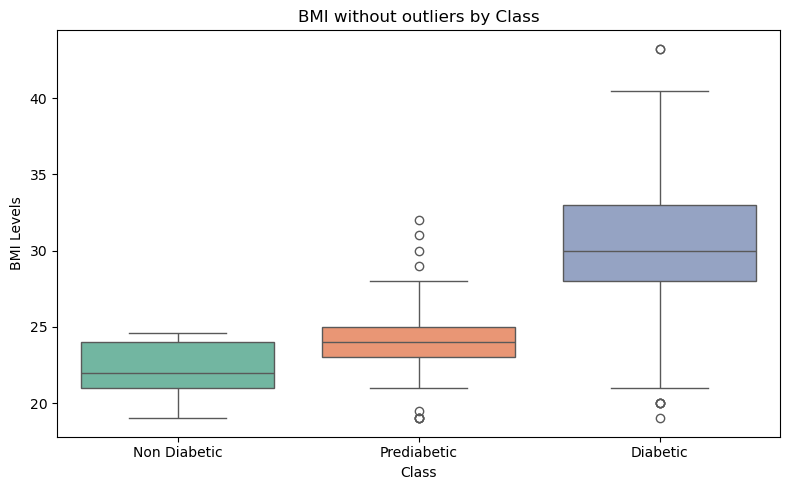


📊 Stats of BMI by Class (without outliers):

              count       mean       std   min   25%   50%   75%    max
class_label                                                            
Diabetic      841.0  30.752878  4.209197  19.0  28.0  30.0  33.0  43.25
Non Diabetic  103.0  22.374757  1.415234  19.0  21.0  22.0  24.0  24.60
Prediabetic    53.0  23.933962  2.713991  19.0  23.0  24.0  25.0  32.00


In [242]:
# Diccionario para mapear clases a etiquetas
class_labels = {1: 'Non Diabetic', 2: 'Prediabetic', 3: 'Diabetic'}

# Lista de columnas clínicas
columns = ['urea', 'cr', 'hba1c', 'chol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi']

for col in columns:
    print(f"\n🔍 Analysis by: {col.upper()}")

    # Calcular IQR y eliminar outliers
    Q1 = df_diabetes[col].quantile(0.25)
    Q3 = df_diabetes[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_no_outliers = df_diabetes[(df_diabetes[col] >= lower_limit) & (df_diabetes[col] <= upper_limit)].copy()

    # Reemplazar valores numéricos por etiquetas
    df_no_outliers['class_label'] = df_no_outliers['class'].map(class_labels)

    print(f'Data Before: {len(df_diabetes)}')
    print(f'Data After remove outliers: {len(df_no_outliers)}')

    # Boxplot por clase con etiquetas
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_no_outliers, x='class_label', y=col, palette='Set2')
    plt.title(f'{col.upper()} without outliers by Class')
    plt.xlabel('Class')
    plt.ylabel(f'{col.upper()} Levels')
    plt.tight_layout()
    plt.show()

    # Estadísticas por clase
    print(f"\n📊 Stats of {col.upper()} by Class (without outliers):\n")
    print(df_no_outliers.groupby('class_label')[col].describe())



🔍 Analysis by: UREA


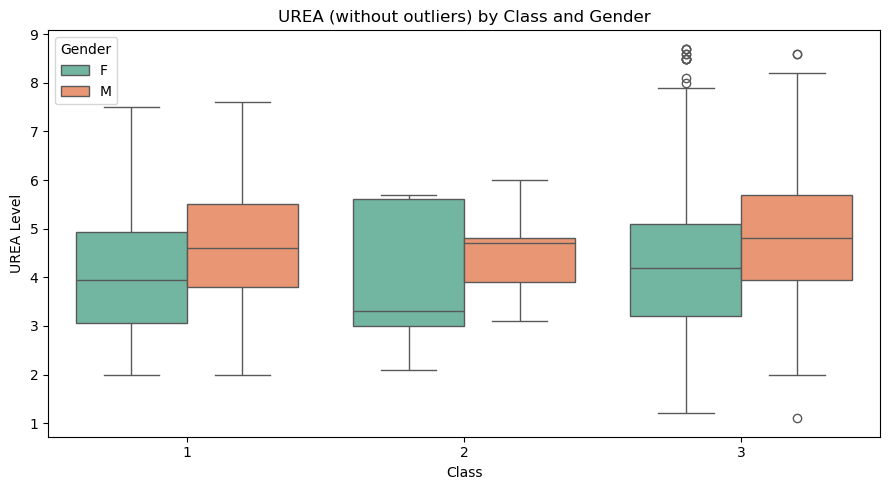


📊 Stats of UREA by class and gender (without outliers):

              count      mean       std  min   25%   50%    75%  max
class gender                                                        
1     F        62.0  4.146774  1.402541  2.0  3.05  3.95  4.925  7.5
      M        37.0  4.591892  1.475236  2.0  3.80  4.60  5.500  7.6
2     F        17.0  3.876471  1.356710  2.1  3.00  3.30  5.600  5.7
      M        35.0  4.460000  0.724041  3.1  3.90  4.70  4.800  6.0
3     F       333.0  4.320420  1.514788  1.2  3.20  4.20  5.100  8.7
      M       451.0  4.837346  1.345676  1.1  3.95  4.80  5.700  8.6

🔍 Analysis by: CR


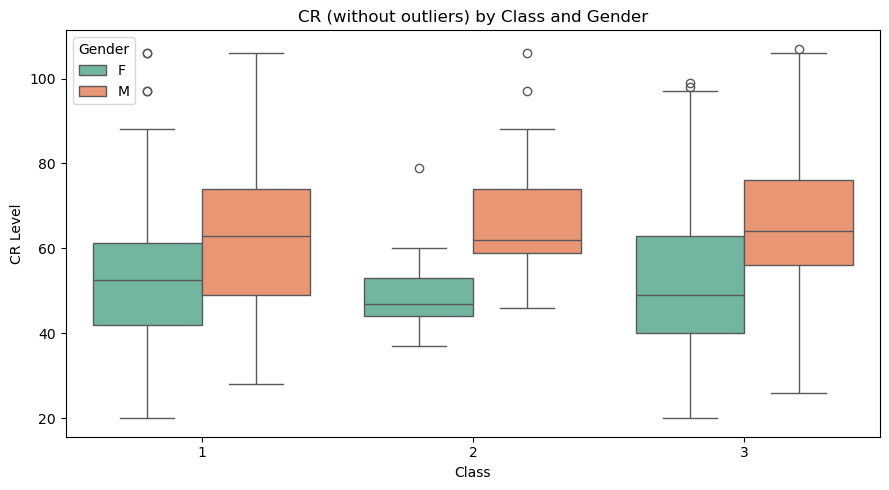


📊 Stats of CR by class and gender (without outliers):

              count       mean        std   min   25%   50%    75%    max
class gender                                                             
1     F        60.0  54.516667  18.850430  20.0  42.0  52.5  61.25  106.0
      M        37.0  64.837838  19.384291  28.0  49.0  63.0  74.00  106.0
2     F        17.0  49.588235  10.006615  37.0  44.0  47.0  53.00   79.0
      M        35.0  66.142857  13.696592  46.0  59.0  62.0  74.00  106.0
3     F       337.0  52.572700  16.767179  20.0  40.0  49.0  63.00   99.0
      M       462.0  65.268398  15.474892  26.0  56.0  64.0  76.00  107.0

🔍 Analysis by: HBA1C


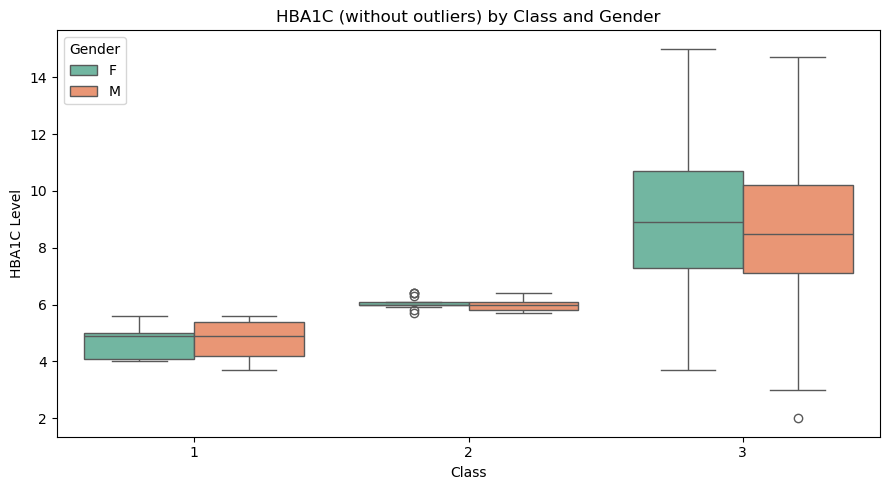


📊 Stats of HBA1C by class and gender (without outliers):

              count      mean       std  min  25%  50%   75%   max
class gender                                                      
1     F        61.0  4.678689  0.536692  4.0  4.1  4.9   5.0   5.6
      M        38.0  4.755263  0.605693  3.7  4.2  4.9   5.4   5.6
2     F        17.0  6.058824  0.203282  5.7  6.0  6.0   6.1   6.4
      M        36.0  5.977778  0.177460  5.7  5.8  6.0   6.1   6.4
3     F       353.0  9.084873  2.429657  3.7  7.3  8.9  10.7  15.0
      M       489.0  8.700204  2.082189  2.0  7.1  8.5  10.2  14.7

🔍 Analysis by: CHOL


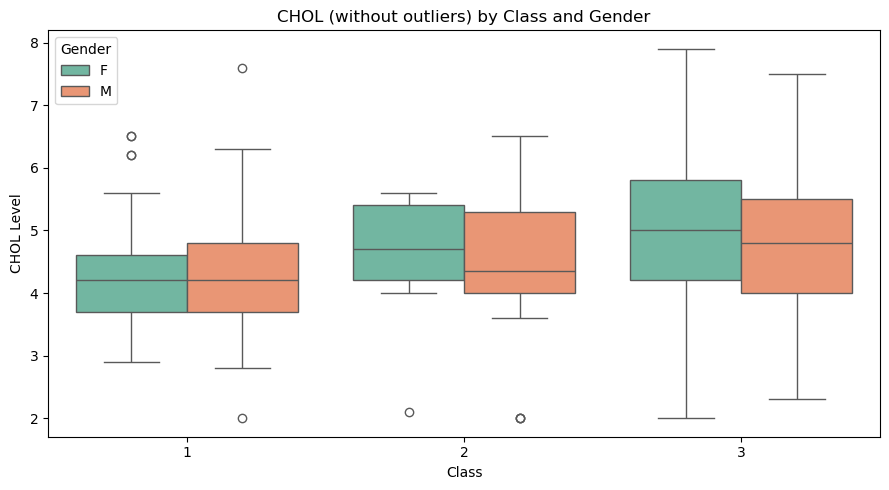


📊 Stats of CHOL by class and gender (without outliers):

              count      mean       std  min  25%   50%  75%  max
class gender                                                     
1     F        61.0  4.244262  0.830968  2.9  3.7  4.20  4.6  6.5
      M        38.0  4.244737  1.013609  2.0  3.7  4.20  4.8  7.6
2     F        17.0  4.747059  0.879003  2.1  4.2  4.70  5.4  5.6
      M        36.0  4.500000  1.114835  2.0  4.0  4.35  5.3  6.5
3     F       345.0  4.984348  1.153931  2.0  4.2  5.00  5.8  7.9
      M       476.0  4.783445  1.075127  2.3  4.0  4.80  5.5  7.5

🔍 Analysis by: TG


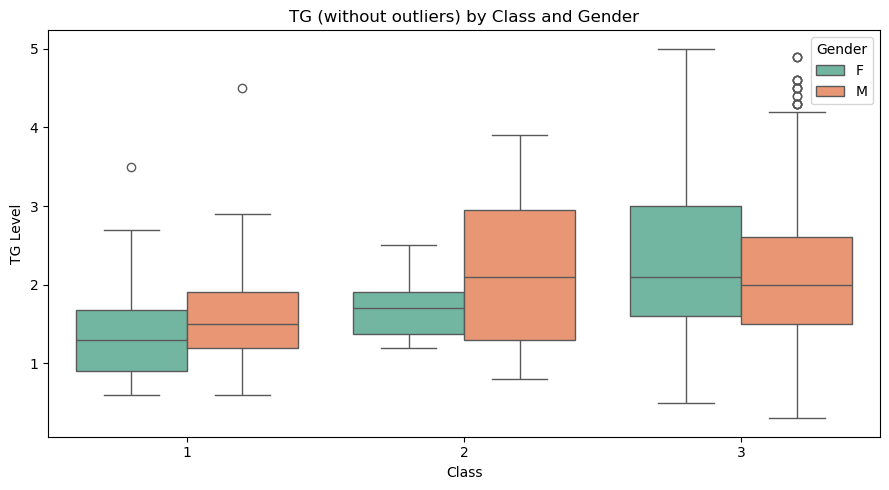


📊 Stats of TG by class and gender (without outliers):

              count      mean       std  min    25%  50%    75%  max
class gender                                                        
1     F        62.0  1.351613  0.540413  0.6  0.900  1.3  1.675  3.5
      M        37.0  1.654054  0.767244  0.6  1.200  1.5  1.900  4.5
2     F        16.0  1.662500  0.373943  1.2  1.375  1.7  1.900  2.5
      M        35.0  2.157143  0.979581  0.8  1.300  2.1  2.950  3.9
3     F       345.0  2.318261  1.012703  0.5  1.600  2.1  3.000  5.0
      M       450.0  2.130467  0.949327  0.3  1.500  2.0  2.600  4.9

🔍 Analysis by: HDL


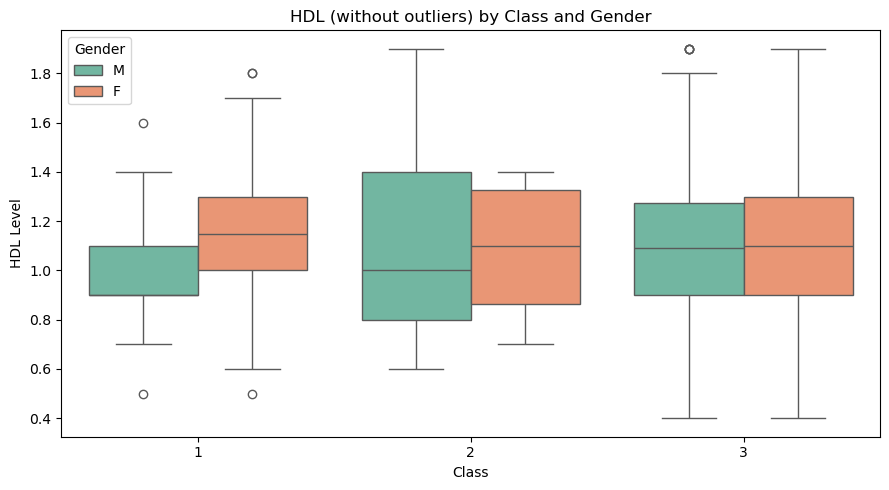


📊 Stats of HDL by class and gender (without outliers):

              count      mean       std  min     25%   50%    75%  max
class gender                                                          
1     F        56.0  1.150000  0.280260  0.5  1.0000  1.15  1.300  1.8
      M        37.0  1.002703  0.221719  0.5  0.9000  0.90  1.100  1.6
2     F        16.0  1.096875  0.269239  0.7  0.8625  1.10  1.325  1.4
      M        36.0  1.102778  0.363700  0.6  0.8000  1.00  1.400  1.9
3     F       331.0  1.138066  0.324506  0.4  0.9000  1.10  1.300  1.9
      M       474.0  1.083122  0.303520  0.4  0.9000  1.09  1.275  1.9

🔍 Analysis by: LDL


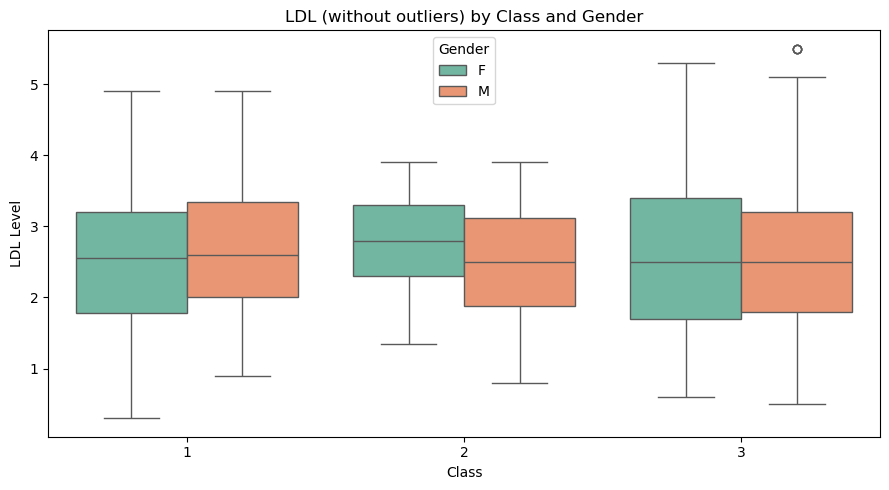


📊 Stats of LDL by class and gender (without outliers):

              count      mean       std   min    25%   50%    75%  max
class gender                                                          
1     F        64.0  2.587500  1.038237  0.30  1.775  2.55  3.200  4.9
      M        39.0  2.687179  0.889760  0.90  2.000  2.60  3.350  4.9
2     F        17.0  2.655882  0.789953  1.35  2.300  2.80  3.300  3.9
      M        36.0  2.416667  0.903801  0.80  1.875  2.50  3.125  3.9
3     F       354.0  2.526441  1.057583  0.60  1.700  2.50  3.400  5.3
      M       479.0  2.575532  0.968846  0.50  1.800  2.50  3.200  5.5

🔍 Analysis by: VLDL


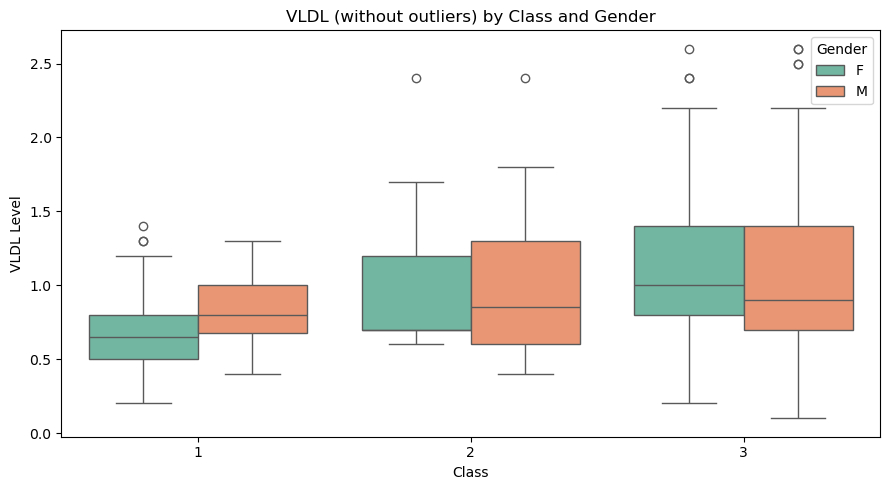


📊 Stats of VLDL by class and gender (without outliers):

              count      mean       std  min    25%   50%  75%  max
class gender                                                       
1     F        64.0  0.690625  0.288245  0.2  0.500  0.65  0.8  1.4
      M        36.0  0.816667  0.251282  0.4  0.675  0.80  1.0  1.3
2     F        17.0  0.982353  0.508964  0.6  0.700  0.70  1.2  2.4
      M        36.0  0.983333  0.505682  0.4  0.600  0.85  1.3  2.4
3     F       352.0  1.091477  0.461122  0.2  0.800  1.00  1.4  2.6
      M       421.0  1.023040  0.471690  0.1  0.700  0.90  1.4  2.6

🔍 Analysis by: BMI


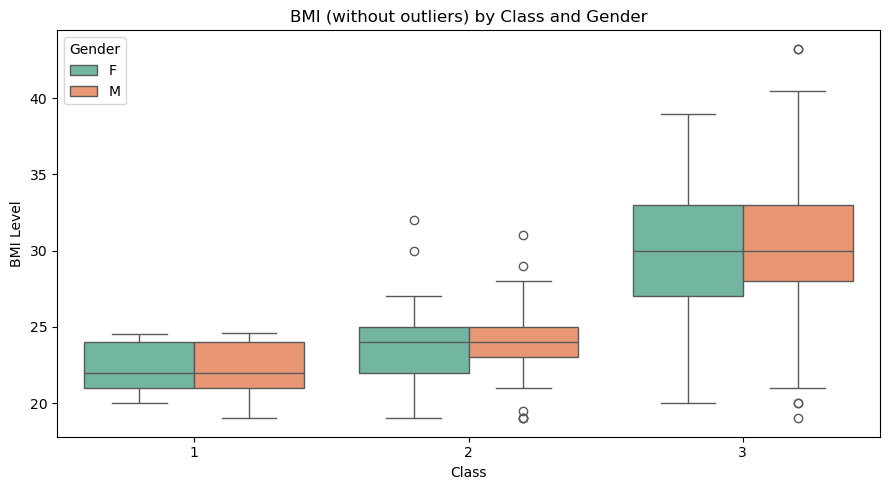


📊 Stats of BMI by class and gender (without outliers):

              count       mean       std   min   25%   50%   75%    max
class gender                                                           
1     F        64.0  22.507812  1.298632  20.0  21.0  22.0  24.0  24.50
      M        39.0  22.156410  1.581604  19.0  21.0  22.0  24.0  24.60
2     F        17.0  24.176471  3.206152  19.0  22.0  24.0  25.0  32.00
      M        36.0  23.819444  2.490418  19.0  23.0  24.0  25.0  31.00
3     F       354.0  30.614859  4.498697  20.0  27.0  30.0  33.0  39.00
      M       487.0  30.853203  3.987328  19.0  28.0  30.0  33.0  43.25


In [243]:
# List of clinical variables to analyze
columns = ['urea', 'cr', 'hba1c', 'chol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi']

for col in columns:
    print(f"\n🔍 Analysis by: {col.upper()}")

    # Remove outliers using IQR
    Q1 = df_diabetes[col].quantile(0.25)
    Q3 = df_diabetes[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_no_outliers = df_diabetes[(df_diabetes[col] >= lower_limit) & (df_diabetes[col] <= upper_limit)]

    # Boxplot with class on x-axis and gender as hue
    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df_no_outliers, x='class', y=col, hue='gender', palette='Set2')
    plt.title(f'{col.upper()} (without outliers) by Class and Gender')
    plt.xlabel('Class')
    plt.ylabel(f'{col.upper()} Level')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()

    # Print stats
    print(f"\n📊 Stats of {col.upper()} by class and gender (without outliers):\n")
    print(df_no_outliers.groupby(['class', 'gender'])[col].describe())


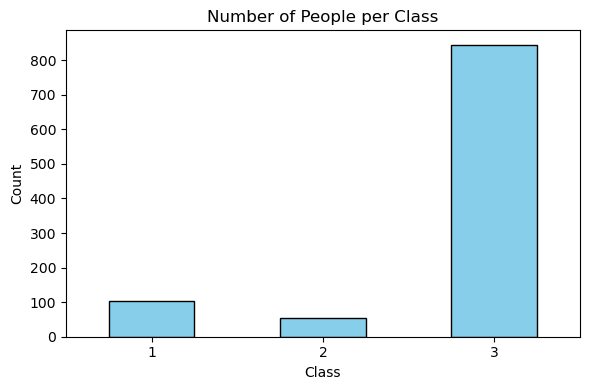

In [244]:
class_counts = df_diabetes.groupby("class")["id"].count()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of People per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Correlation

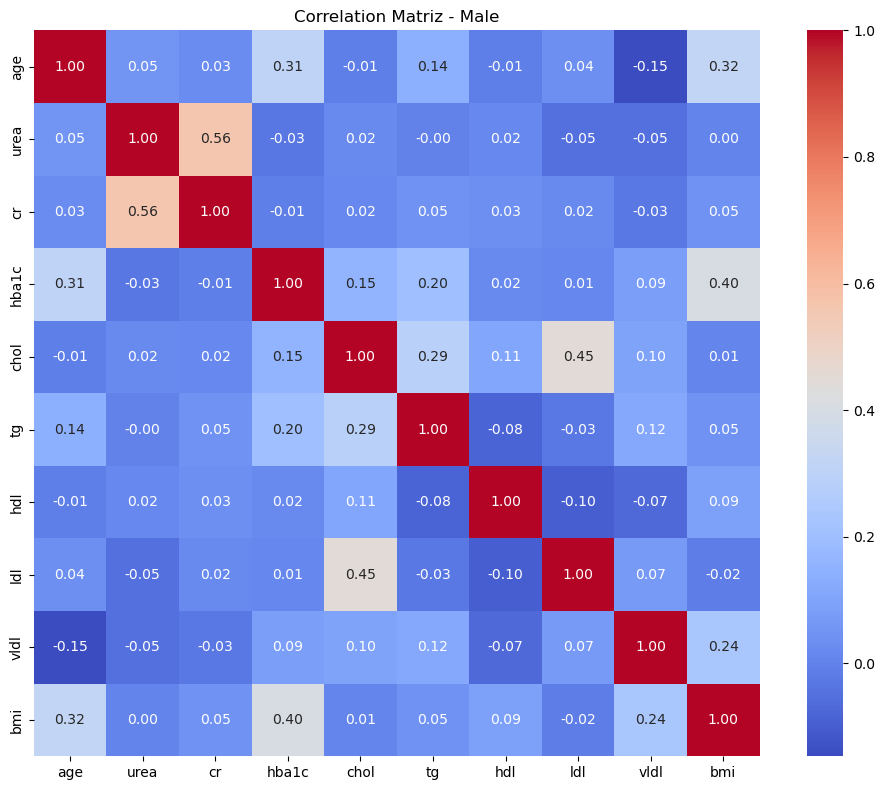

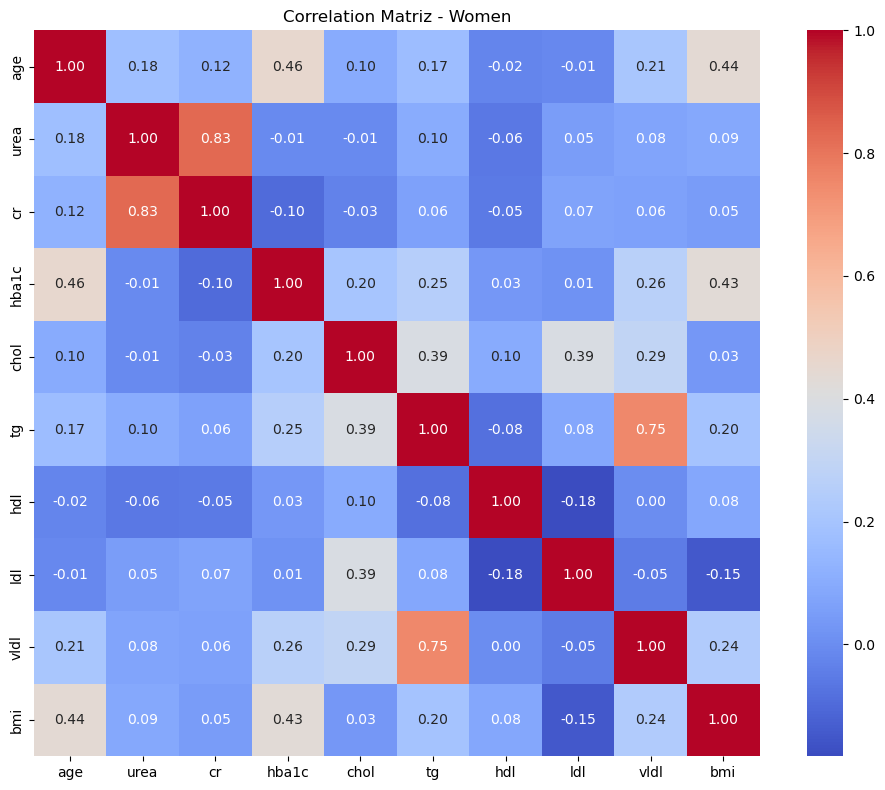

In [245]:
columns = ['age','urea', 'cr', 'hba1c', 'chol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi']

# Data Frames by Gender
df_male = df_diabetes[df_diabetes['gender'] == 'M'][columns]
df_female = df_diabetes[df_diabetes['gender'] == 'F'][columns]

# Calcular la matriz de correlación
corr_male = df_male.corr()
corr_female = df_female.corr()

# Plot matriz for Males
plt.figure(figsize=(10, 8))
sns.heatmap(corr_male, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matriz - Male')
plt.tight_layout()
plt.show()

# Plot matriz for Womens
plt.figure(figsize=(10, 8))
sns.heatmap(corr_female, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matriz - Women')
plt.tight_layout()
plt.show()


## A/B TEST
- CR (Creatina)
Creatinine level in the blood (likely measured in mg/dL or µmol/L). Creatinine is another waste product that indicates kidney function.

In [246]:
print('Female Creatina Info')
cr_f=df_diabetes[df_diabetes['gender']=="F"]['cr']
#print(cr_f)
print('Female Creatina Stats', cr_f.describe())
print()

print('Male Creatina Info')
cr_m=df_diabetes[df_diabetes['gender']=="M"]['cr']
#print(cr_m)
print('Male Creatina Stats', cr_m.describe())

Female Creatina Info
Female Creatina Stats count    435.000000
mean      58.360920
std       37.519406
min        6.000000
25%       41.000000
50%       52.000000
75%       66.000000
max      401.000000
Name: cr, dtype: float64

Male Creatina Info
Male Creatina Stats count    565.000000
mean      77.090265
std       71.674654
min       26.000000
25%       56.000000
50%       65.000000
75%       77.000000
max      800.000000
Name: cr, dtype: float64


Normality Test

In [247]:
shapiro_f = shapiro(cr_f)
shapiro_m = shapiro(cr_m)

print("Shapiro-Wilk Femenino:", shapiro_f.pvalue)
print("Shapiro-Wilk Masculino:", shapiro_m.pvalue)

Shapiro-Wilk Femenino: 5.365208948438347e-32
Shapiro-Wilk Masculino: 4.383261596408028e-41


CR data do not follow a normal distribution in either men or women.

Levene Test

In [248]:
levene_test = levene(cr_f, cr_m)
print("Prueba de Levene:", levene_test.pvalue)

Prueba de Levene: 0.15791526814487056


In [249]:
stat, p = mannwhitneyu(cr_f, cr_m, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p}")

if p < 0.05:
    print("✅ H₀ is rejected: There is a significant difference in CR values between men and women.")
else:
    print("🟡 H₀ is not rejected: There is no statistically significant difference in CR values between men and women.")

Mann-Whitney U statistic: 71446.0
P-value: 6.34382610102047e-30
✅ H₀ is rejected: There is a significant difference in CR values between men and women.


## A/B Test without Outliers by Gender

In [250]:
def filterbygender(df, col_grupo, col_valor):
    grupos = df[col_grupo].unique()
    df_filtrado = pd.DataFrame()

    for g in grupos:
        grupo_df = df[df[col_grupo] == g]
        Q1 = grupo_df[col_valor].quantile(0.25)
        Q3 = grupo_df[col_valor].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        filtrado = grupo_df[(grupo_df[col_valor] >= lower) & (grupo_df[col_valor] <= upper)]
        df_filtrado = pd.concat([df_filtrado, filtrado])

    return df_filtrado

# Aplicar a tu caso:
df_nooutliers = filterbygender(df_diabetes, 'gender', 'cr')

# Luego separar para el test
cr_f = df_nooutliers[df_nooutliers['gender'] == 'F']['cr']
cr_m = df_nooutliers[df_nooutliers['gender'] == 'M']['cr']


Nomality Test

In [251]:
shapiro_f = shapiro(cr_f)
shapiro_m = shapiro(cr_m)

print("Shapiro-Wilk Femenino:", shapiro_f.pvalue)
print("Shapiro-Wilk Masculino:", shapiro_m.pvalue)

Shapiro-Wilk Femenino: 2.796596731968748e-08
Shapiro-Wilk Masculino: 0.001312235021032393


Levene Test

In [252]:
levene_test = levene(cr_f, cr_m)
print("Prueba de Levene:", levene_test.pvalue)

Prueba de Levene: 0.3070232447688928


In [253]:
stat, p = mannwhitneyu(cr_f, cr_m, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p}")

if p < 0.05:
    print("✅ H₀ is rejected: There is a significant difference in CR values between men and women.")
else:
    print("🟡 H₀ is not rejected: There is no statistically significant difference in CR values between men and women.")

Mann-Whitney U statistic: 59538.0
P-value: 5.225240463522244e-34
✅ H₀ is rejected: There is a significant difference in CR values between men and women.


## VLDL A/B TEST
VLDL: Very low-density lipoprotein cholesterol level (measured in mg/dL or mmol/L)

In [254]:
print('Female VLDL Info')
vldl_f=df_diabetes[df_diabetes['gender']=="F"]['vldl']
#print(vldl_f)
print('Female VLDL Stats', vldl_f.describe())
print()

print('Male VLDL Info')
vldl_m=df_diabetes[df_diabetes['gender']=="M"]['vldl']
#print(vldl_m)
print('Male VLDL Stats', vldl_m.describe())

Female VLDL Info
Female VLDL Stats count    435.000000
mean       1.044598
std        0.535201
min        0.200000
25%        0.700000
50%        0.900000
75%        1.300000
max        6.300000
Name: vldl, dtype: float64

Male VLDL Info
Male VLDL Stats count    565.000000
mean       2.478407
std        4.760013
min        0.100000
25%        0.700000
50%        0.900000
75%        1.500000
max       35.000000
Name: vldl, dtype: float64


Normality Test

In [255]:
shapiro_f = shapiro(vldl_f)
shapiro_m = shapiro(vldl_m)

print("Shapiro-Wilk Femenino:", shapiro_f.pvalue)
print("Shapiro-Wilk Masculino:", shapiro_m.pvalue)

Shapiro-Wilk Femenino: 3.43998858172346e-20
Shapiro-Wilk Masculino: 1.0687061592708719e-38


Levene Test

In [256]:
levene_test = levene(cr_f, cr_m)
print("Prueba de Levene:", levene_test.pvalue)

Prueba de Levene: 0.3070232447688928


In [257]:
stat, p = mannwhitneyu(vldl_f, vldl_m, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p}")

if p < 0.05:
    print("✅ H₀ is rejected: There is a significant difference in VLDL values between men and women.")
else:
    print("🟡 H₀ is not rejected: There is no statistically significant difference in VLDL values between men and women.")

Mann-Whitney U statistic: 111967.0
P-value: 0.01559916746905963
✅ H₀ is rejected: There is a significant difference in VLDL values between men and women.


## VLDL without Outliers

In [258]:
def filterbygender(df, col_grupo, col_valor):
    grupos = df[col_grupo].unique()
    df_filtrado = pd.DataFrame()

    for g in grupos:
        grupo_df = df[df[col_grupo] == g]
        Q1 = grupo_df[col_valor].quantile(0.25)
        Q3 = grupo_df[col_valor].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        filtrado = grupo_df[(grupo_df[col_valor] >= lower) & (grupo_df[col_valor] <= upper)]
        df_filtrado = pd.concat([df_filtrado, filtrado])

    return df_filtrado

# Aplicar a tu caso:
df_nooutliers = filterbygender(df_diabetes, 'gender', 'vldl')

# Luego separar para el test
vldl_f = df_nooutliers[df_nooutliers['gender'] == 'F']['vldl']
vldl_m = df_nooutliers[df_nooutliers['gender'] == 'M']['vldl']


Normality Test

In [259]:
shapiro_f = shapiro(vldl_f)
shapiro_m = shapiro(vldl_m)

print("Shapiro-Wilk Femenino:", shapiro_f.pvalue)
print("Shapiro-Wilk Masculino:", shapiro_m.pvalue)

Shapiro-Wilk Femenino: 1.3515485397519456e-09
Shapiro-Wilk Masculino: 3.8129772234572756e-13


Levene Test

In [260]:
levene_test = levene(cr_f, cr_m)
print("Prueba de Levene:", levene_test.pvalue)

Prueba de Levene: 0.3070232447688928


In [261]:
stat, p = mannwhitneyu(vldl_f, vldl_m, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p}")

if p < 0.05:
    print("✅ H₀ is rejected: There is a significant difference in VLDL values between men and women.")
else:
    print("🟡 H₀ is not rejected: There is no statistically significant difference in VLDL values between men and women.")

Mann-Whitney U statistic: 109006.0
P-value: 0.4177810485766096
🟡 H₀ is not rejected: There is no statistically significant difference in VLDL values between men and women.


## Kruskal-Wallis by HBA1C
Diabetic, Pre-Diabetic, Non Diabetic

In [262]:
# Mapear etiquetas descriptivas (opcional)
df_diabetes['class_label'] = df_diabetes['class'].map({1: 'Non Diabetic', 2: 'Prediabetic', 3: 'Diabetic'})

# Without Outliers
Q1 = df_diabetes['hba1c'].quantile(0.25)
Q3 = df_diabetes['hba1c'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_no_outliers = df_diabetes[(df_diabetes['hba1c'] >= lower_limit) & (df_diabetes['hba1c'] <= upper_limit)]

# Data per Classes
class1 = df_no_outliers[df_no_outliers['class'] == 1]['hba1c']
class2 = df_no_outliers[df_no_outliers['class'] == 2]['hba1c']
class3 = df_no_outliers[df_no_outliers['class'] == 3]['hba1c']

Normality Test

In [263]:
print("🔎 Shapiro-Wilk Test for Normality: \n")
for group, name in zip([class1, class2, class3], ['Non Diabetic', 'Prediabetic', 'Diabetic']):
    stat, p = shapiro(group)
    print(f"{name}: p-value = {p:.4f} {'❌ Not normal' if p < 0.05 else '✅ Normal'}")

🔎 Shapiro-Wilk Test for Normality: 

Non Diabetic: p-value = 0.0000 ❌ Not normal
Prediabetic: p-value = 0.0053 ❌ Not normal
Diabetic: p-value = 0.0000 ❌ Not normal


In [264]:
# Levene Test
stat_levene, p_levene = levene(class1, class2, class3)
print(f"Levene’s Test for equal variances: p-value = {p_levene:.4f}")
if p_levene < 0.05:
    print("⚠️ Ha: Variances are not equal")
else:
    print("✅ Ho: Variances are homogeneous")

Levene’s Test for equal variances: p-value = 0.0000
⚠️ Ha: Variances are not equal


In [265]:
# Aplicar Kruskal-Wallis
h_stat, p_kw = kruskal(class1, class2, class3)

print("\nKruskal–Wallis Test (non-parametric):")
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_kw:.4f}")

if p_kw < 0.05:
    print("✅ Statistically significant difference in HBA1C levels between groups (reject H₀)")
else:
    print("🟡 No statistically significant difference in HBA1C levels between groups (fail to reject H₀)")


Kruskal–Wallis Test (non-parametric):
H-statistic: 324.7307
P-value: 0.0000
✅ Statistically significant difference in HBA1C levels between groups (reject H₀)


## 4 Data Models

ONE HOT ENCODING

In [266]:
numerical_var=['age','urea','cr','hba1c','chol','tg','hdl','ldl','vldl','bmi']
print(numerical_var)

['age', 'urea', 'cr', 'hba1c', 'chol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi']


In [267]:
df_diabetes = df_diabetes.drop(['id', 'no_pation'], axis=1)
print(df_diabetes.head())
print()
df_diabetes_ohe=pd.get_dummies(df_diabetes,drop_first=True)
print(df_diabetes_ohe.head())

  gender  age  urea  cr  hba1c  chol   tg  hdl  ldl  vldl   bmi  class  \
0      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1   
1      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      1   
2      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1   
3      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1   
4      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      1   

    class_label  
0  Non Diabetic  
1  Non Diabetic  
2  Non Diabetic  
3  Non Diabetic  
4  Non Diabetic  

   age  urea  cr  hba1c  chol   tg  hdl  ldl  vldl   bmi  class  gender_M  \
0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1     False   
1   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      1      True   
2   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1     False   
3   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1     False   
4   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0     

Split Data Set by Training, Validation and Test

In [268]:
index_train_valid,index_test=train_test_split(df_diabetes.index,test_size=0.2,random_state=12345)
index_train,index_valid=train_test_split(index_train_valid,test_size=0.25,random_state=12345)

df_train=df_diabetes.loc[index_train]
df_valid=df_diabetes.loc[index_valid]
df_test=df_diabetes.loc[index_test]

df_ohe_train=df_diabetes_ohe.loc[index_train]
df_ohe_valid=df_diabetes_ohe.loc[index_valid]
df_ohe_test=df_diabetes_ohe.loc[index_test]

print('Training',df_train.shape)
print('Valid',df_valid.shape)
print('Testing',df_test.shape)
print()

print('Training',df_ohe_train.shape)
print('Valid',df_ohe_valid.shape)
print('Testing',df_ohe_test.shape)

Training (600, 13)
Valid (200, 13)
Testing (200, 13)

Training (600, 14)
Valid (200, 14)
Testing (200, 14)


In [269]:
#Trainning
features_train_ohe=df_ohe_train.drop(['class'],axis=1)
target_train_ohe=df_ohe_train['class']
#Valid
features_valid_ohe=df_ohe_valid.drop(['class'],axis=1)
target_valid_ohe=df_ohe_valid['class']
#Testing
features_test_ohe=df_ohe_test.drop(['class'],axis=1)
target_test_ohe=df_ohe_test['class']

Scaler with Standar Scaler

In [270]:
scaler=StandardScaler()
features_train_ohe[numerical_var]=scaler.fit_transform(features_train_ohe[numerical_var])
features_valid_ohe[numerical_var]=scaler.transform(features_valid_ohe[numerical_var])
features_test_ohe[numerical_var]=scaler.transform(features_test_ohe[numerical_var])

SMOTE Balance

class
3    0.84
1    0.11
2    0.05
Name: proportion, dtype: float64


<Axes: xlabel='class'>

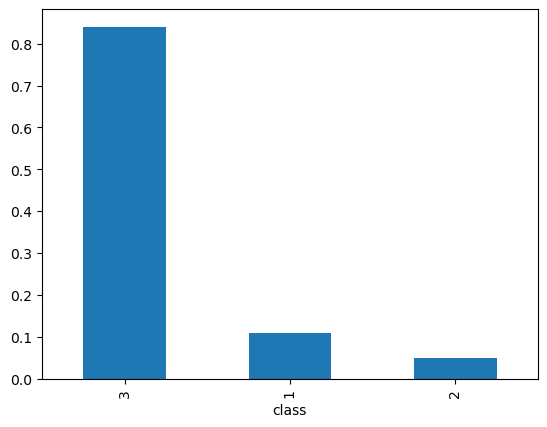

In [271]:
print(target_train_ohe.value_counts(normalize=True))
target_train_ohe.value_counts(normalize=True).plot(kind='bar')

In [272]:
smote = SMOTE(random_state=42)

# Only for Training Data
features_train_smote, target_train_smote = smote.fit_resample(features_train_ohe, target_train_ohe)

print("Antes del balanceo:", Counter(target_train_ohe))
print("Después del balanceo:", Counter(target_train_smote))

Antes del balanceo: Counter({3: 504, 1: 66, 2: 30})
Después del balanceo: Counter({1: 504, 3: 504, 2: 504})


## 4.1 Logisctic Regression

In [273]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    print("🔹 EVALUATION ON TRAINING SET")
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("🔹 EVALUATION ON VALIDATION SET")
    y_pred_valid = model.predict(X_valid)
    print(confusion_matrix(y_valid, y_pred_valid))
    print(classification_report(y_valid, y_pred_valid))

    print("🔹 EVALUATION ON TEST SET")
    y_pred_test = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))

In [274]:
model_lr = LogisticRegression(max_iter=1000, random_state=12345)
model_lr.fit(features_train_smote, target_train_smote)

LogisticRegression(max_iter=1000, random_state=12345)

In [275]:
evaluate_model(model_lr, features_train_smote,target_train_smote,features_valid_ohe,target_valid_ohe,features_test_ohe,target_test_ohe)

🔹 EVALUATION ON TRAINING SET
[[504   0   0]
 [  0 504   0]
 [  0   0 504]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       504
           2       1.00      1.00      1.00       504
           3       1.00      1.00      1.00       504

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512

🔹 EVALUATION ON VALIDATION SET
[[ 22   0   0]
 [  0   8   0]
 [  0   0 170]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00       170

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

🔹 EVALUATION ON TEST SET
[[ 15   0   0]
 [  0  15   0]
 [  0   0 170]]
              p

## 4.2 SVM Model

In [276]:
# Assure Balanced Clasess
print("Balanced class distribution:", Counter(target_train_smote))

# Modelo SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=12345)
svm_model.fit(features_train_ohe, target_train_ohe)

Balanced class distribution: Counter({1: 504, 3: 504, 2: 504})


SVC(C=1, random_state=12345)

In [277]:
evaluate_model(svm_model, features_train_smote,target_train_smote,features_valid_ohe,target_valid_ohe,features_test_ohe,target_test_ohe)

🔹 EVALUATION ON TRAINING SET
[[504   0   0]
 [  0 504   0]
 [  0   0 504]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       504
           2       1.00      1.00      1.00       504
           3       1.00      1.00      1.00       504

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512

🔹 EVALUATION ON VALIDATION SET
[[ 21   0   1]
 [  0   7   1]
 [  0   0 170]]
              precision    recall  f1-score   support

           1       1.00      0.95      0.98        22
           2       1.00      0.88      0.93         8
           3       0.99      1.00      0.99       170

    accuracy                           0.99       200
   macro avg       1.00      0.94      0.97       200
weighted avg       0.99      0.99      0.99       200

🔹 EVALUATION ON TEST SET
[[ 15   0   0]
 [  0  15   0]
 [  0   0 170]]
              p

In [278]:
svm_balanced = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', random_state=12345)
svm_balanced.fit(features_train_smote, target_train_smote)

SVC(C=1, class_weight='balanced', random_state=12345)

In [279]:
evaluate_model(svm_balanced, features_train_smote,target_train_smote,features_valid_ohe,target_valid_ohe,features_test_ohe,target_test_ohe)

🔹 EVALUATION ON TRAINING SET
[[504   0   0]
 [  0 504   0]
 [  0   0 504]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       504
           2       1.00      1.00      1.00       504
           3       1.00      1.00      1.00       504

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512

🔹 EVALUATION ON VALIDATION SET
[[ 21   0   1]
 [  0   7   1]
 [  0   0 170]]
              precision    recall  f1-score   support

           1       1.00      0.95      0.98        22
           2       1.00      0.88      0.93         8
           3       0.99      1.00      0.99       170

    accuracy                           0.99       200
   macro avg       1.00      0.94      0.97       200
weighted avg       0.99      0.99      0.99       200

🔹 EVALUATION ON TEST SET
[[ 15   0   0]
 [  0  15   0]
 [  0   0 170]]
              p

# Ordinal Encoding

In [280]:
df_diabetes.drop(['class_label'], axis=1, inplace=True)
categorical_features=['gender']
df_diabetes[categorical_features]=OrdinalEncoder().fit_transform(df_diabetes[categorical_features])
print(df_diabetes)

     gender  age  urea  cr  hba1c  chol   tg  hdl  ldl  vldl   bmi  class
0       0.0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1
1       1.0   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      1
2       0.0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1
3       0.0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1
4       1.0   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      1
..      ...  ...   ...  ..    ...   ...  ...  ...  ...   ...   ...    ...
995     1.0   71  11.0  97    7.0   7.5  1.7  1.2  1.8   0.6  30.0      3
996     1.0   31   3.0  60   12.3   4.1  2.2  0.7  2.4  15.4  37.2      3
997     1.0   30   7.1  81    6.7   4.1  1.1  1.2  2.4   8.1  27.4      3
998     1.0   38   5.8  59    6.7   5.3  2.0  1.6  2.9  14.0  40.5      3
999     1.0   54   5.0  67    6.9   3.8  1.7  1.1  3.0   0.7  33.0      3

[1000 rows x 12 columns]


Data Split: Features, Target and Test

In [281]:
features = df_diabetes.drop(columns=['class'])  
target = df_diabetes['class']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.2, random_state=12345)

print('Training')
print(features_train.shape)
print(target_train.shape)

print('Validation')
print(features_valid.shape)
print(target_valid.shape)

print('Test')
print(features_test.shape)
print(target_test.shape)

Training
(640, 11)
(640,)
Validation
(160, 11)
(160,)
Test
(200, 11)
(200,)


Target training Distribution:
class
3    0.835938
1    0.114062
2    0.050000
Name: proportion, dtype: float64


<Axes: xlabel='class'>

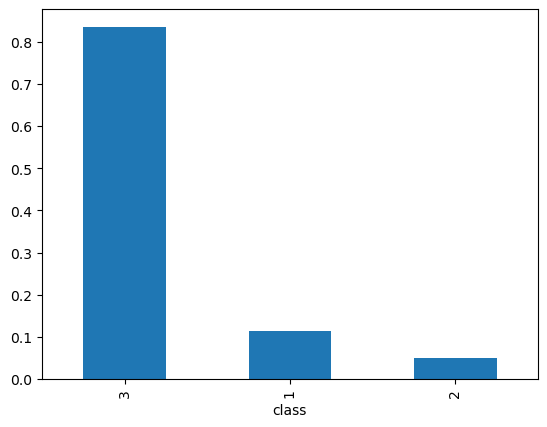

In [282]:
print("Target training Distribution:")
print(target_train.value_counts(normalize=True))
target_train.value_counts(normalize=True).plot(kind='bar')

In [283]:
# Aplicar SMOTE solo en el conjunto de entrenamiento
smote = SMOTE(random_state=12345)
features_train_res, target_train_res = smote.fit_resample(features_train, target_train)

# Verificar el nuevo balance
print("🔍 Clase antes del balanceo:", Counter(target_train))
print("✅ Clase después del balanceo con SMOTE:", Counter(target_train_res))

🔍 Clase antes del balanceo: Counter({3: 535, 1: 73, 2: 32})
✅ Clase después del balanceo con SMOTE: Counter({3: 535, 2: 535, 1: 535})


## Tree Classifier

In [284]:
# Entrenamiento y evaluación por profundidad
for depth in range(1, 11):
    print("\n" + "="*40)
    print(f"🌳 Tree Depth: {depth}")

    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train_res, target_train_res)  # Usamos datos balanceados

    # Predicciones
    predicted_train = model_tree.predict(features_train_res)
    predicted_valid = model_tree.predict(features_valid)
    predicted_test = model_tree.predict(features_test)

    # Métricas
    score_train = accuracy_score(target_train_res, predicted_train)
    score_valid = accuracy_score(target_valid, predicted_valid)
    score_test = accuracy_score(target_test, predicted_test)
    f1_valid = f1_score(target_valid, predicted_valid, average='macro')

    # ROC-AUC para multiclase con binarización
    target_valid_bin = label_binarize(target_valid, classes=[1, 2, 3])
    proba_valid = model_tree.predict_proba(features_valid)
    roc_auc_valid = roc_auc_score(target_valid_bin, proba_valid, average='macro', multi_class='ovr')

    # Mostrar métricas resumen
    print(f"✅ Accuracy (Train): {score_train:.4f}")
    print(f"✅ Accuracy (Validation): {score_valid:.4f}")
    print(f"✅ Accuracy (Test): {score_test:.4f}")
    print(f"📈 F1-Score (macro): {f1_valid:.4f}")
    print(f"📊 ROC-AUC (macro): {roc_auc_valid:.4f}")



🌳 Tree Depth: 1
✅ Accuracy (Train): 0.6667
✅ Accuracy (Validation): 0.1313
✅ Accuracy (Test): 0.1500
📈 F1-Score (macro): 0.2980
📊 ROC-AUC (macro): 0.7931

🌳 Tree Depth: 2
✅ Accuracy (Train): 0.9763
✅ Accuracy (Validation): 0.9500
✅ Accuracy (Test): 0.9350
📈 F1-Score (macro): 0.8618
📊 ROC-AUC (macro): 0.9848

🌳 Tree Depth: 3
✅ Accuracy (Train): 0.9875
✅ Accuracy (Validation): 0.9750
✅ Accuracy (Test): 0.9700
📈 F1-Score (macro): 0.9346
📊 ROC-AUC (macro): 0.9954

🌳 Tree Depth: 4
✅ Accuracy (Train): 0.9969
✅ Accuracy (Validation): 0.9812
✅ Accuracy (Test): 0.9700
📈 F1-Score (macro): 0.9301
📊 ROC-AUC (macro): 0.9935

🌳 Tree Depth: 5
✅ Accuracy (Train): 0.9994
✅ Accuracy (Validation): 0.9875
✅ Accuracy (Test): 0.9700
📈 F1-Score (macro): 0.9612
📊 ROC-AUC (macro): 0.9954

🌳 Tree Depth: 6
✅ Accuracy (Train): 1.0000
✅ Accuracy (Validation): 0.9812
✅ Accuracy (Test): 0.9700
📈 F1-Score (macro): 0.9499
📊 ROC-AUC (macro): 0.9930

🌳 Tree Depth: 7
✅ Accuracy (Train): 1.0000
✅ Accuracy (Validation): 0

## Random Forest

In [285]:
print('🌲 Random Forest:\n')

for n_tree in range(1, 10, 1):
    model_forest = RandomForestClassifier(n_estimators=n_tree, random_state=12345)
    model_forest.fit(features_train_res, target_train_res)
    
    predictions_valid = model_forest.predict(features_valid)
    
    # ROC-AUC fix
    target_valid_bin = label_binarize(target_valid, classes=[1, 2, 3])
    probas_valid = model_forest.predict_proba(features_valid)
    roc_auc = roc_auc_score(target_valid_bin, probas_valid, multi_class='ovr', average='macro')

    print(f'Tree Number: {n_tree}')
    print('Training:', model_forest.score(features_train_res, target_train_res))
    print('Validation:', model_forest.score(features_valid, target_valid))
    print('Testing:', model_forest.score(features_test, target_test))
    print('F1-score (macro):', f1_score(target_valid, predictions_valid, average='macro'))
    print('ROC-AUC (macro):', roc_auc)
    print()


🌲 Random Forest:

Tree Number: 1
Training: 0.990031152647975
Validation: 0.98125
Testing: 0.955
F1-score (macro): 0.9438905180840664
ROC-AUC (macro): 0.942889629183353

Tree Number: 2
Training: 0.9881619937694704
Validation: 0.95
Testing: 0.89
F1-score (macro): 0.7935665307928081
ROC-AUC (macro): 0.9580565731024674

Tree Number: 3
Training: 0.9962616822429906
Validation: 0.95625
Testing: 0.965
F1-score (macro): 0.8481332236263776
ROC-AUC (macro): 0.9588442546455447

Tree Number: 4
Training: 0.9975077881619938
Validation: 0.95625
Testing: 0.96
F1-score (macro): 0.839975845410628
ROC-AUC (macro): 0.9925190774384522

Tree Number: 5
Training: 0.9987538940809969
Validation: 0.98125
Testing: 0.97
F1-score (macro): 0.9438905180840664
ROC-AUC (macro): 0.998142646652942

Tree Number: 6
Training: 0.9981308411214953
Validation: 0.9875
Testing: 0.97
F1-score (macro): 0.9565461999901546
ROC-AUC (macro): 0.9989254686711894

Tree Number: 7
Training: 0.9993769470404984
Validation: 0.98125
Testing: 0.9

## CAT BOOST

In [286]:
# Asegurarse que las columnas categóricas sean tipo str
for df in [features_train, features_valid, features_test]:
    df['gender'] = df['gender'].astype(str)

# Definir correctamente las columnas categóricas
categorical_cols = ['gender']

# 🔢 Binarizar target para ROC-AUC y LogLoss multiclase
target_train_bin = label_binarize(target_train, classes=[1, 2, 3])
target_valid_bin = label_binarize(target_valid, classes=[1, 2, 3])
target_test_bin  = label_binarize(target_test,  classes=[1, 2, 3])

# 📦 Modelo CatBoost
model_cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    random_seed=12345,
    verbose=25
)

# 🧠 Entrenamiento
model_cat.fit(
    features_train,
    target_train,
    cat_features=categorical_features,
    eval_set=(features_valid, target_valid),
    early_stopping_rounds=50
)

0:	learn: 0.9769604	test: 0.9739532	best: 0.9739532 (0)	total: 3.45ms	remaining: 1.03s
25:	learn: 0.1538921	test: 0.1526066	best: 0.1526066 (25)	total: 54.5ms	remaining: 575ms
50:	learn: 0.0619382	test: 0.0743202	best: 0.0743202 (50)	total: 103ms	remaining: 503ms
75:	learn: 0.0346168	test: 0.0548056	best: 0.0548056 (75)	total: 149ms	remaining: 438ms
100:	learn: 0.0226902	test: 0.0445636	best: 0.0445636 (100)	total: 194ms	remaining: 383ms
125:	learn: 0.0163949	test: 0.0391043	best: 0.0391043 (125)	total: 249ms	remaining: 344ms
150:	learn: 0.0127870	test: 0.0374584	best: 0.0372599 (142)	total: 320ms	remaining: 315ms
175:	learn: 0.0104144	test: 0.0366478	best: 0.0365526 (173)	total: 385ms	remaining: 271ms
200:	learn: 0.0086516	test: 0.0363180	best: 0.0361520 (199)	total: 455ms	remaining: 224ms
225:	learn: 0.0073472	test: 0.0360710	best: 0.0359604 (224)	total: 510ms	remaining: 167ms
250:	learn: 0.0064145	test: 0.0356284	best: 0.0356197 (247)	total: 563ms	remaining: 110ms
275:	learn: 0.0057

In [287]:
# 🔮 Predicciones
pred_train = model_cat.predict(features_train)
pred_valid = model_cat.predict(features_valid)
pred_test  = model_cat.predict(features_test)

prob_train = model_cat.predict_proba(features_train)
prob_valid = model_cat.predict_proba(features_valid)
prob_test  = model_cat.predict_proba(features_test)

In [288]:
# 📊 Métricas
auc_train = roc_auc_score(target_train_bin, prob_train, multi_class='ovr', average='macro')
auc_valid = roc_auc_score(target_valid_bin, prob_valid, multi_class='ovr', average='macro')
auc_test  = roc_auc_score(target_test_bin, prob_test, multi_class='ovr', average='macro')

acc_train = accuracy_score(target_train, pred_train)
acc_valid = accuracy_score(target_valid, pred_valid)
acc_test  = accuracy_score(target_test, pred_test)

f1_valid = f1_score(target_valid, pred_valid, average='macro')
logloss_valid = log_loss(target_valid, prob_valid)

In [289]:
# 📈 Mostrar resultados
print(f"\n🌟 CatBoost Metrics:")
print(f"🔹 AUC-ROC Train: {auc_train:.4f}")
print(f"🔹 AUC-ROC Valid: {auc_valid:.4f}")
print(f"🔹 AUC-ROC Test : {auc_test:.4f}")
print()
print(f"✅ Accuracy Train: {acc_train:.4f}")
print(f"✅ Accuracy Valid: {acc_valid:.4f}")
print(f"✅ Accuracy Test : {acc_test:.4f}")
print()
print(f"📈 F1-Score (macro, Valid): {f1_valid:.4f}")
print(f"📉 Log Loss (Valid): {logloss_valid:.4f}")
print()

# 🧾 Reportes completos
print("🔹 Confusion Matrix (Validation):")
print(confusion_matrix(target_valid, pred_valid))

print("\n🔹 Classification Report (Validation):")
print(classification_report(target_valid, pred_valid))


🌟 CatBoost Metrics:
🔹 AUC-ROC Train: 1.0000
🔹 AUC-ROC Valid: 0.9990
🔹 AUC-ROC Test : 0.9983

✅ Accuracy Train: 1.0000
✅ Accuracy Valid: 0.9875
✅ Accuracy Test : 0.9800

📈 F1-Score (macro, Valid): 0.9565
📉 Log Loss (Valid): 0.0353

🔹 Confusion Matrix (Validation):
[[ 15   0   0]
 [  0   5   1]
 [  1   0 138]]

🔹 Classification Report (Validation):
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.83      0.91         6
           3       0.99      0.99      0.99       139

    accuracy                           0.99       160
   macro avg       0.98      0.94      0.96       160
weighted avg       0.99      0.99      0.99       160

